### **Exploring the Efficacy of Latent Dirichlet Allocation and BERTopic for Topic Modeling in Optimizing English-Filipino ASR-Derived Speech Content Analysis**  

FLORA, Jane Frances Ma. Vianney P.  
TALAVERA, Joanna Elaine J.  

**CHAPTER III - METHODS | CODE IMPLEMENTATION**



### Installing Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Installing dependecies

# !pip install gensim
!pip install bertopic
# !pip install scikit-learn
# !pip install tqdm
# !pip install transformers
# !pip install numpy pandas matplotlib seaborn
!pip install jiwer
!pip install Datasets
!pip install nltk

# For podcast transcription

# !pip install whisper

In [ ]:
# Importing Dependencies

import gensim
from bertopic import BERTopic
import sklearn
import tqdm
import transformers
import jiwer
import datasets
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from scipy.sparse import issparse
import torch
from gensim import corpora
from transformers import pipeline

# Miscellaneous Dependencies

import os
import glob
import re
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from gensim import corpora

# For visualization

import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### The Dataset  

In [ ]:
# Define your directories
directories = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Initialize an empty list to store the documents
data = []

In [ ]:
# Loop through each directory and read text files
for directory in directories:
    # Get all text files in the current directory
    text_files = glob.glob(os.path.join(directory, '*.txt'))

    # Read each text file and append its content to the data list
    for file_path in text_files:
        with open(file_path, 'r') as file:
            content = file.read()
            data.append(content)

In [ ]:
# Print the number of documents loaded
num_documents = len(data)
print(f"Number of documents: {num_documents}")

Number of documents: 21


In [ ]:
# Assuming 'data' contains the loaded documents
first_document = data[0]

# Tokenize the document into sentences
sentences = nltk.sent_tokenize(first_document)

# Display the first 5 sentences
for i, sentence in enumerate(sentences[:5]):
    print(f"Sentence {i+1}:\n{sentence}\n")

Sentence 1:
Hmm.

Sentence 2:
Hello everyone!

Sentence 3:
Ang ganda ng topic natin ngayon, no?

Sentence 4:
Bakit nga ba mahirap mahalin ang sarili?

Sentence 5:
Bakit ba?



In [ ]:
# Function to calculate total words and characters
def calculate_corpus_statistics(documents):
    total_words = 0
    total_characters = 0
    for doc in documents:
        total_words += len(doc.split())
        total_characters += len(doc)
    return total_words, total_characters

In [ ]:
# Calculate and display corpus quantities
total_words, total_characters = calculate_corpus_statistics(data)
print(f"Total number of words: {total_words}")
print(f"Total number of characters: {total_characters}")

Total number of words: 56377
Total number of characters: 318311


### Text Preprocessing


In [ ]:
# Define English stopwords
english_stopwords = set(stopwords.words('english'))

# Load Tagalog stopwords from file
tagalog_stopwords_file = "/content/drive/MyDrive/Thesis Data/stopwords-tl.txt"
with open(tagalog_stopwords_file, 'r') as f:
    tagalog_stopwords = set(f.read().splitlines())

# Combine English and Tagalog stopwords
all_stopwords = english_stopwords.union(tagalog_stopwords)

In [ ]:
print(all_stopwords)

{'', 'narito', 'him', 'down', 'll', 'nga', 'isang', "you've", 'marapat', 'ano', 'mong', 'them', 'pamamagitan', 'their', 'his', 'pataas', 'ah', 'by', 'haven', 'did', 'herself', 'palabas', 'in', 'our', 'to', 'm', 'shan', 'me', "weren't", 'mustn', 'where', 'below', 'hasn', 'weren', 'paano', 'bawat', 'nilang', 'kumuha', 'alin', 'or', 'ko', 'akin', 'doon', 'you', 'may', 'such', "hasn't", "shouldn't", 'itself', 'karamihan', 'tungkol', 'an', 'out', 'iyon', 'pagkatapos', 'very', 'laban', 'apat', 'again', 'not', 'ako', 'maging', 'kayo', 'ain', 'ngayon', 'saan', 'kulang', 'whom', 'while', 'won', 'gusto', 'rin', 'ibaba', 'we', 'kami', 'lahat', 'be', 'all', "that'll", 'nyo', 'is', 'noon', 'kanino', 'further', "you'll", 'muna', 'isn', 'during', 'of', 'lamang', 's', 'naging', 'on', "wouldn't", 'pero', 'these', 'oo', 'up', 'should', 'pumupunta', "mightn't", 'pa', 'nor', 'it', 'dapat', 'ginawa', 'paggawa', 'bakit', 'am', 'katiyakan', 'at', 'more', 'ma', 'kaysa', 'akong', 'my', 'napaka', 'sarili', 'off

In [ ]:
import os
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define stopwords and lemmatizer
stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define directories for text files
directories = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Read and combine text files from directories into one corpus
def read_combine_files(directories):
    corpus = []
    for directory in directories:
        files = os.listdir(directory)
        for file in files:
            file_path = os.path.join(directory, file)
            with open(file_path, 'r') as f:
                text = f.read()
                corpus.append(text)
    return corpus

# Function to preprocess a single document
def preprocess_document(document):
    # Remove non-alphanumeric characters and convert to lowercase
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', document.lower())
    # Tokenize the text
    words = word_tokenize(cleaned_text)
    # Remove stopwords
    filtered_words = [word for word in words if word not in all_stopwords]
    # Lemmatize the words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    # Join lemmatized words back into a string
    processed_text = ' '.join(lemmatized_words)
    return processed_text

# Preprocess the corpus by removing stopwords and lemmatizing
def preprocess_corpus(corpus):
    processed_corpus = [preprocess_document(doc) for doc in corpus]
    return processed_corpus

# Read and combine text files from directories into corpus
corpus = read_combine_files(directories)

# Preprocess the corpus
processed_corpus = preprocess_corpus(corpus)

# Print an example of processed document
print(processed_corpus[0])  # Print the first processed document to verify

# Tokenize the processed corpus
tokens = [doc.split() for doc in processed_corpus]

# Print an example of tokens
print(tokens[0])  # Print tokens of the first document to verify

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


hmm hello everyone ganda topic mahirap mahalin totoo mahirapan mahalin mahalin mere fact nandito nagiexist kamahalmahal ganon mahirap mahalin welcome mind buddy millennial psychologist rian portuguese service siyempre siyempre nagtanong nung nakaraan mahirap mahalin ifeature listener napakainteresting sagot naghalohalo tema siyempre imemention tema nakuha audience alam makakarelate maiba tema sagot kinalaman condition worth maiba pagbibigay atensyon maiba pagkafroy desire namang kinalaman pagkukumpara simulan meron talagang naganswer mahirap daw mahalin keji dinedepende worth standard mahirap habulin ideal sineset naisip order worthy must please people feed ego mahal feel worthy nagsastart pagmamahal well fact first place validation love desire must came alam katotohanan sinabi time akala talagang mahal alam source love nagagaling ibang tao teka wala namang masama source love nagagaling ibang tao psychology fact pinaguusapan teorya mahalaga mabuild foundation love trust pang essential 

In [ ]:
documents = [' '.join(doc) for doc in tokens]

In [ ]:
print(documents)

['hmm hello everyone ganda topic mahirap mahalin totoo mahirapan mahalin mahalin mere fact nandito nagiexist kamahalmahal ganon mahirap mahalin welcome mind buddy millennial psychologist rian portuguese service siyempre siyempre nagtanong nung nakaraan mahirap mahalin ifeature listener napakainteresting sagot naghalohalo tema siyempre imemention tema nakuha audience alam makakarelate maiba tema sagot kinalaman condition worth maiba pagbibigay atensyon maiba pagkafroy desire namang kinalaman pagkukumpara simulan meron talagang naganswer mahirap daw mahalin keji dinedepende worth standard mahirap habulin ideal sineset naisip order worthy must please people feed ego mahal feel worthy nagsastart pagmamahal well fact first place validation love desire must came alam katotohanan sinabi time akala talagang mahal alam source love nagagaling ibang tao teka wala namang masama source love nagagaling ibang tao psychology fact pinaguusapan teorya mahalaga mabuild foundation love trust pang essentia

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


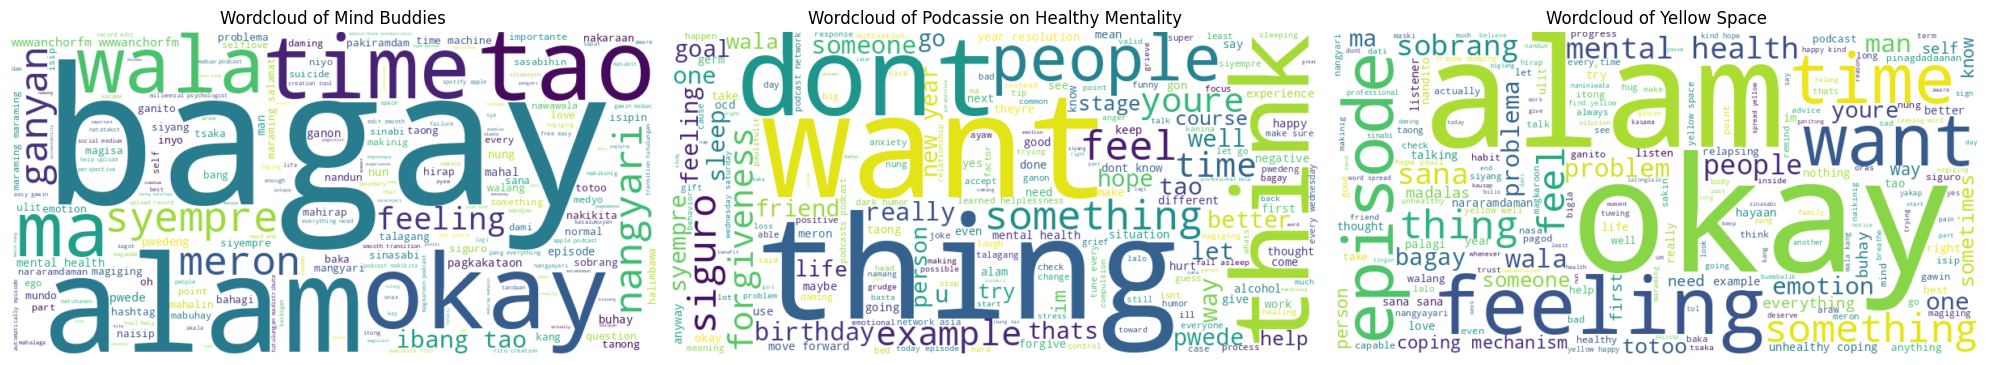

In [ ]:
# VISUALIZATION | CREATING WORDCLOUD

#!pip install nltk wordcloud
import os
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Define directories for text files
directories = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Define English stopwords
english_stopwords = set(stopwords.words('english'))

# Load Tagalog stopwords from file
tagalog_stopwords_file = "/content/drive/MyDrive/Thesis Data/stopwords-tl.txt"
with open(tagalog_stopwords_file, 'r') as f:
    tagalog_stopwords = set(f.read().splitlines())

# Combine English and Tagalog stopwords
all_stopwords = english_stopwords.union(tagalog_stopwords)

# Function to read files from a directory
def read_files_from_directory(directory):
    corpus = []
    for file in sorted(os.listdir(directory)):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            text = f.read()
            corpus.append(text)
    return corpus

# Function to lemmatize words
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(word) for word in words]
    return lemma_words

# Function to preprocess the corpus
def preprocess_corpus(corpus, stopwords):
    processed_corpus = []
    for document in corpus:
        cleaned_text = re.sub(r'[^a-zA-Z\s]', '', document.lower())
        words = word_tokenize(cleaned_text)
        filtered_words = [word for word in words if word not in stopwords]
        lemmatized_words = lemmatize_words(filtered_words)
        processed_text = ' '.join(lemmatized_words)
        processed_corpus.append(processed_text)
    return processed_corpus

# Function to generate and display a word cloud
def generate_wordcloud(text, title, ax):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title)
    ax.axis('off')

# Read, preprocess and combine text for each podcast show
podcast_titles = ["Mind Buddies", "Podcassie on Healthy Mentality", "Yellow Space"]
combined_texts = []

for directory in directories:
    # Read files
    corpus = read_files_from_directory(directory)

    # Preprocess corpus
    processed_corpus = preprocess_corpus(corpus, all_stopwords)

    # Combine all episodes into one text
    combined_text = ' '.join(processed_corpus)
    combined_texts.append(combined_text)

# Generate and display word clouds for each podcast show in subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
for i, combined_text in enumerate(combined_texts):
    title = f"Wordcloud of {podcast_titles[i]}"
    generate_wordcloud(combined_text, title, axes[i])

plt.tight_layout()
plt.show()

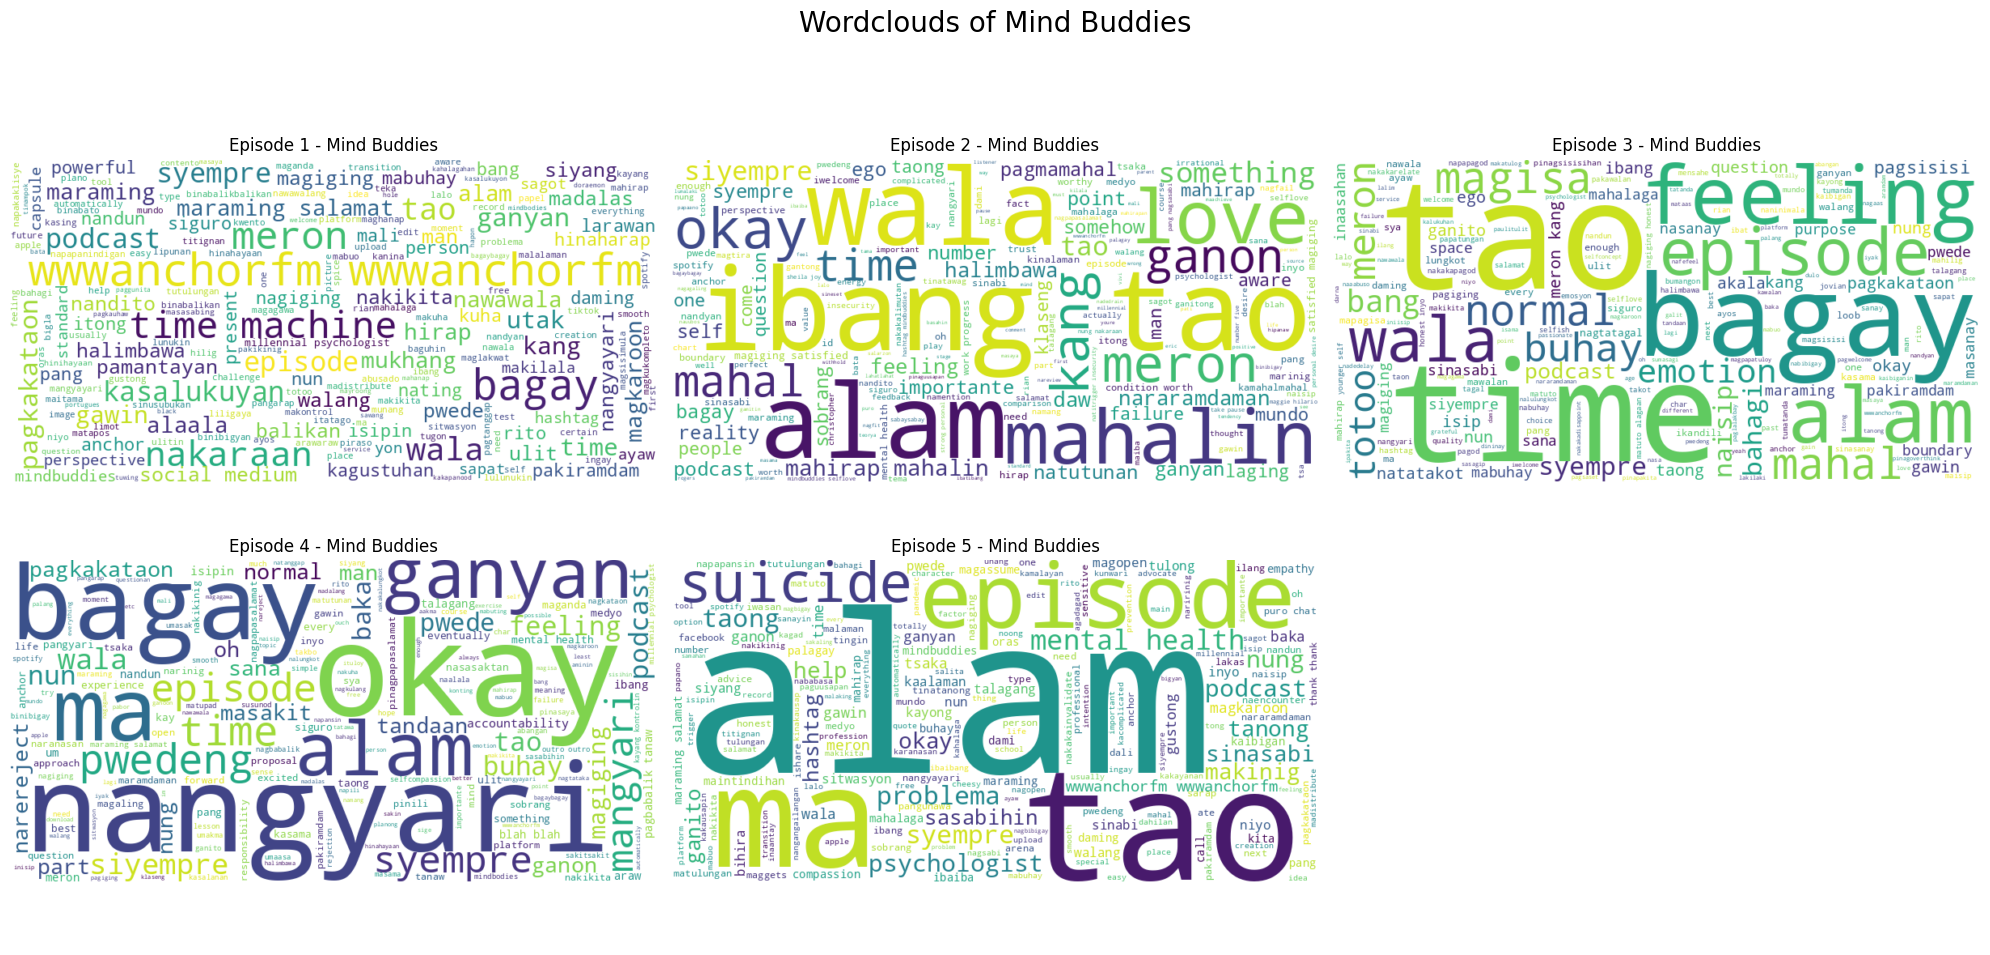

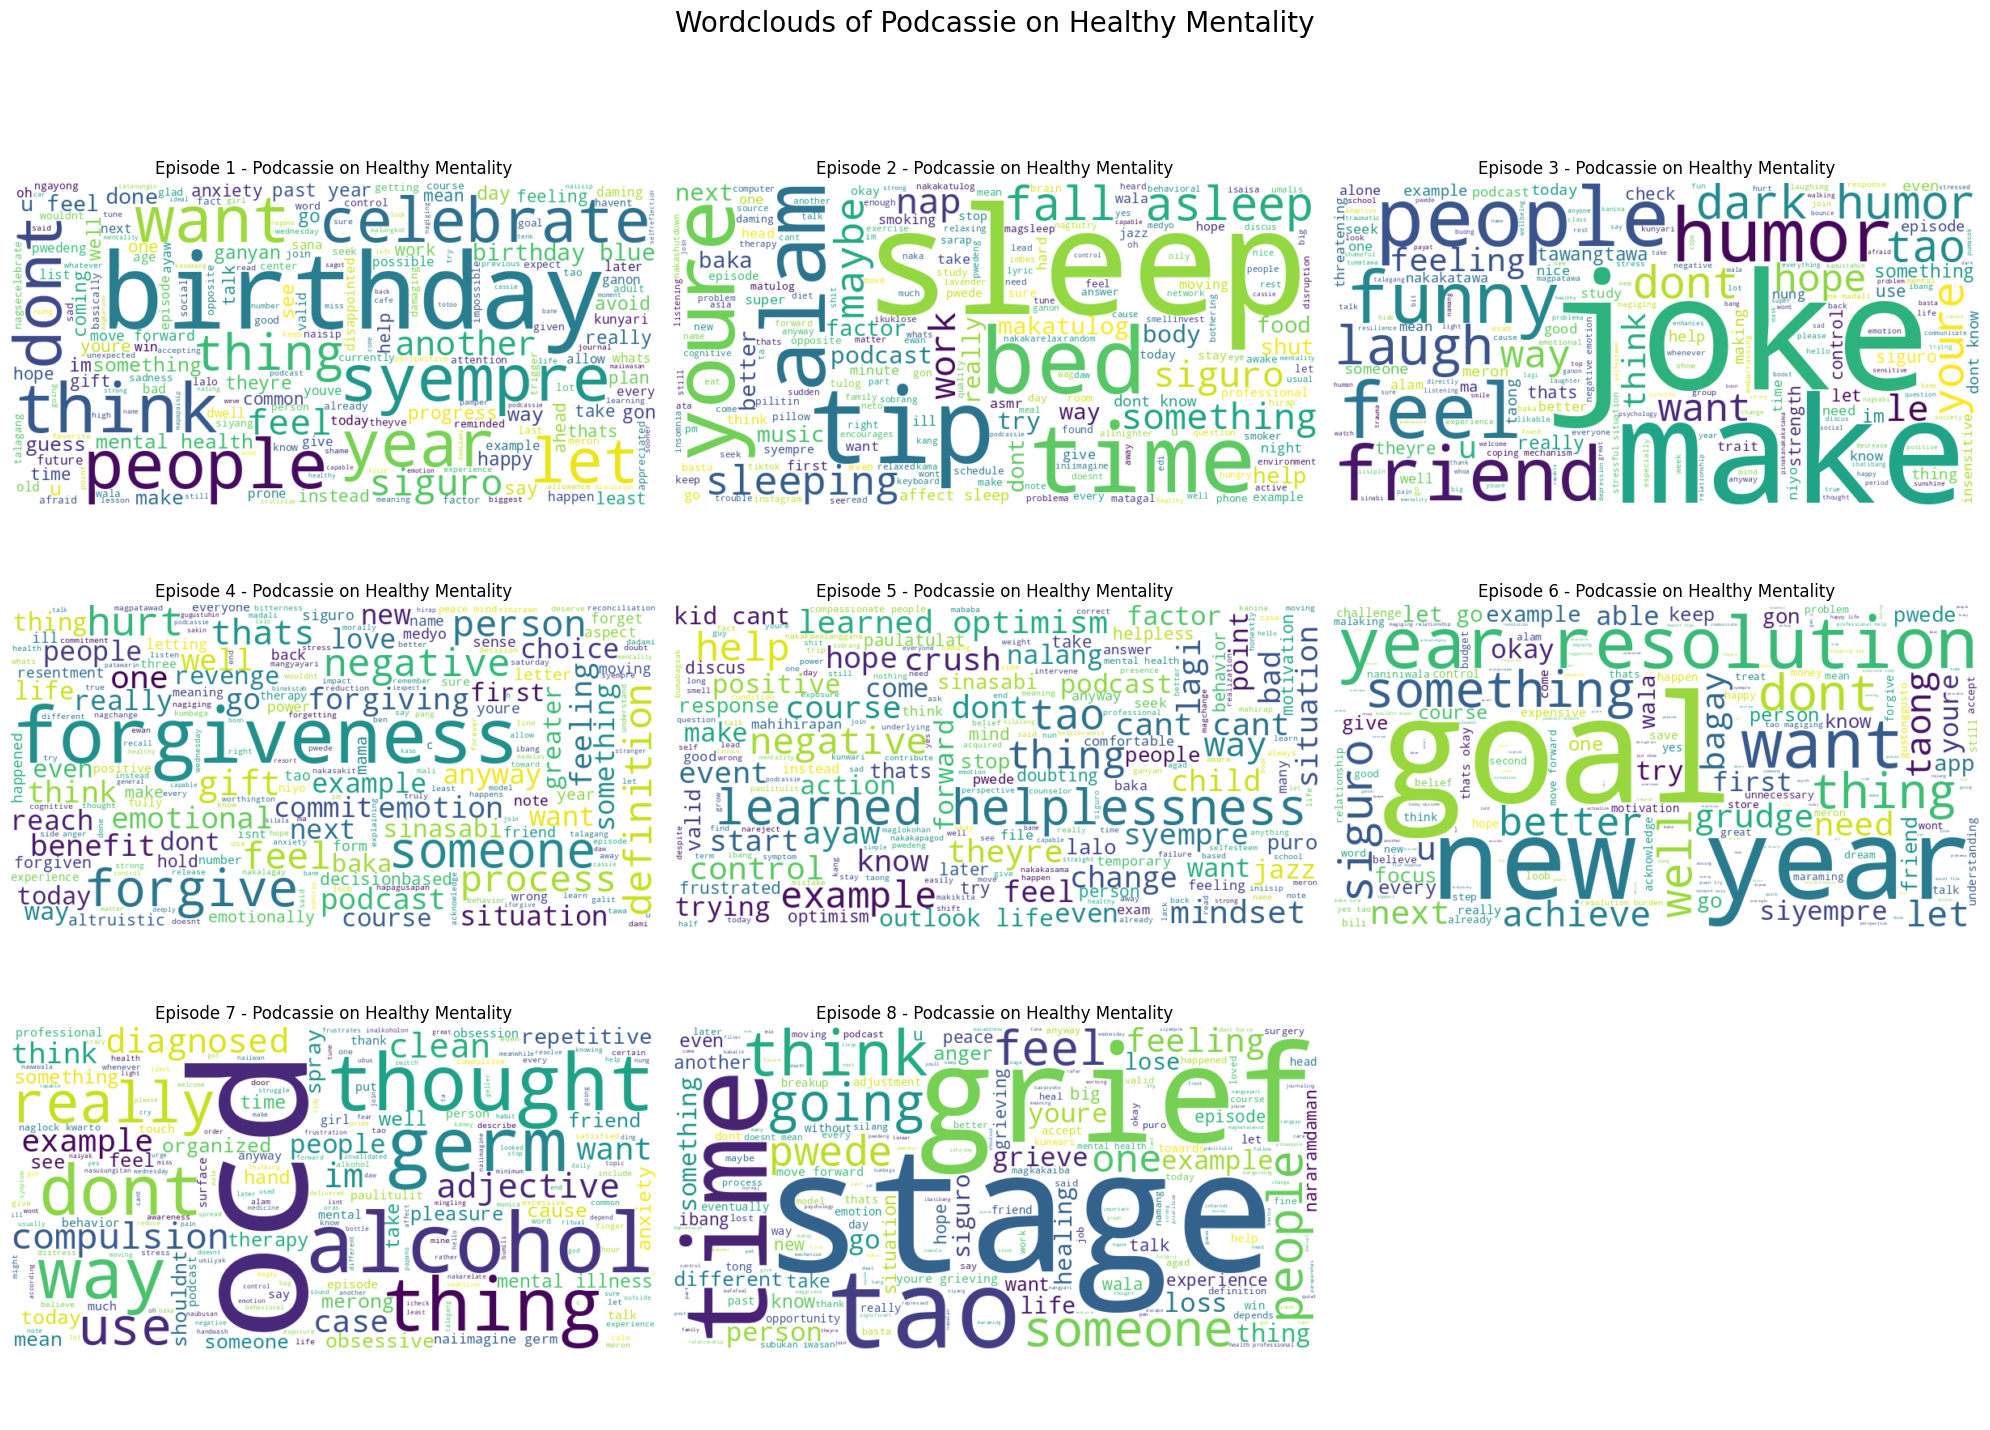

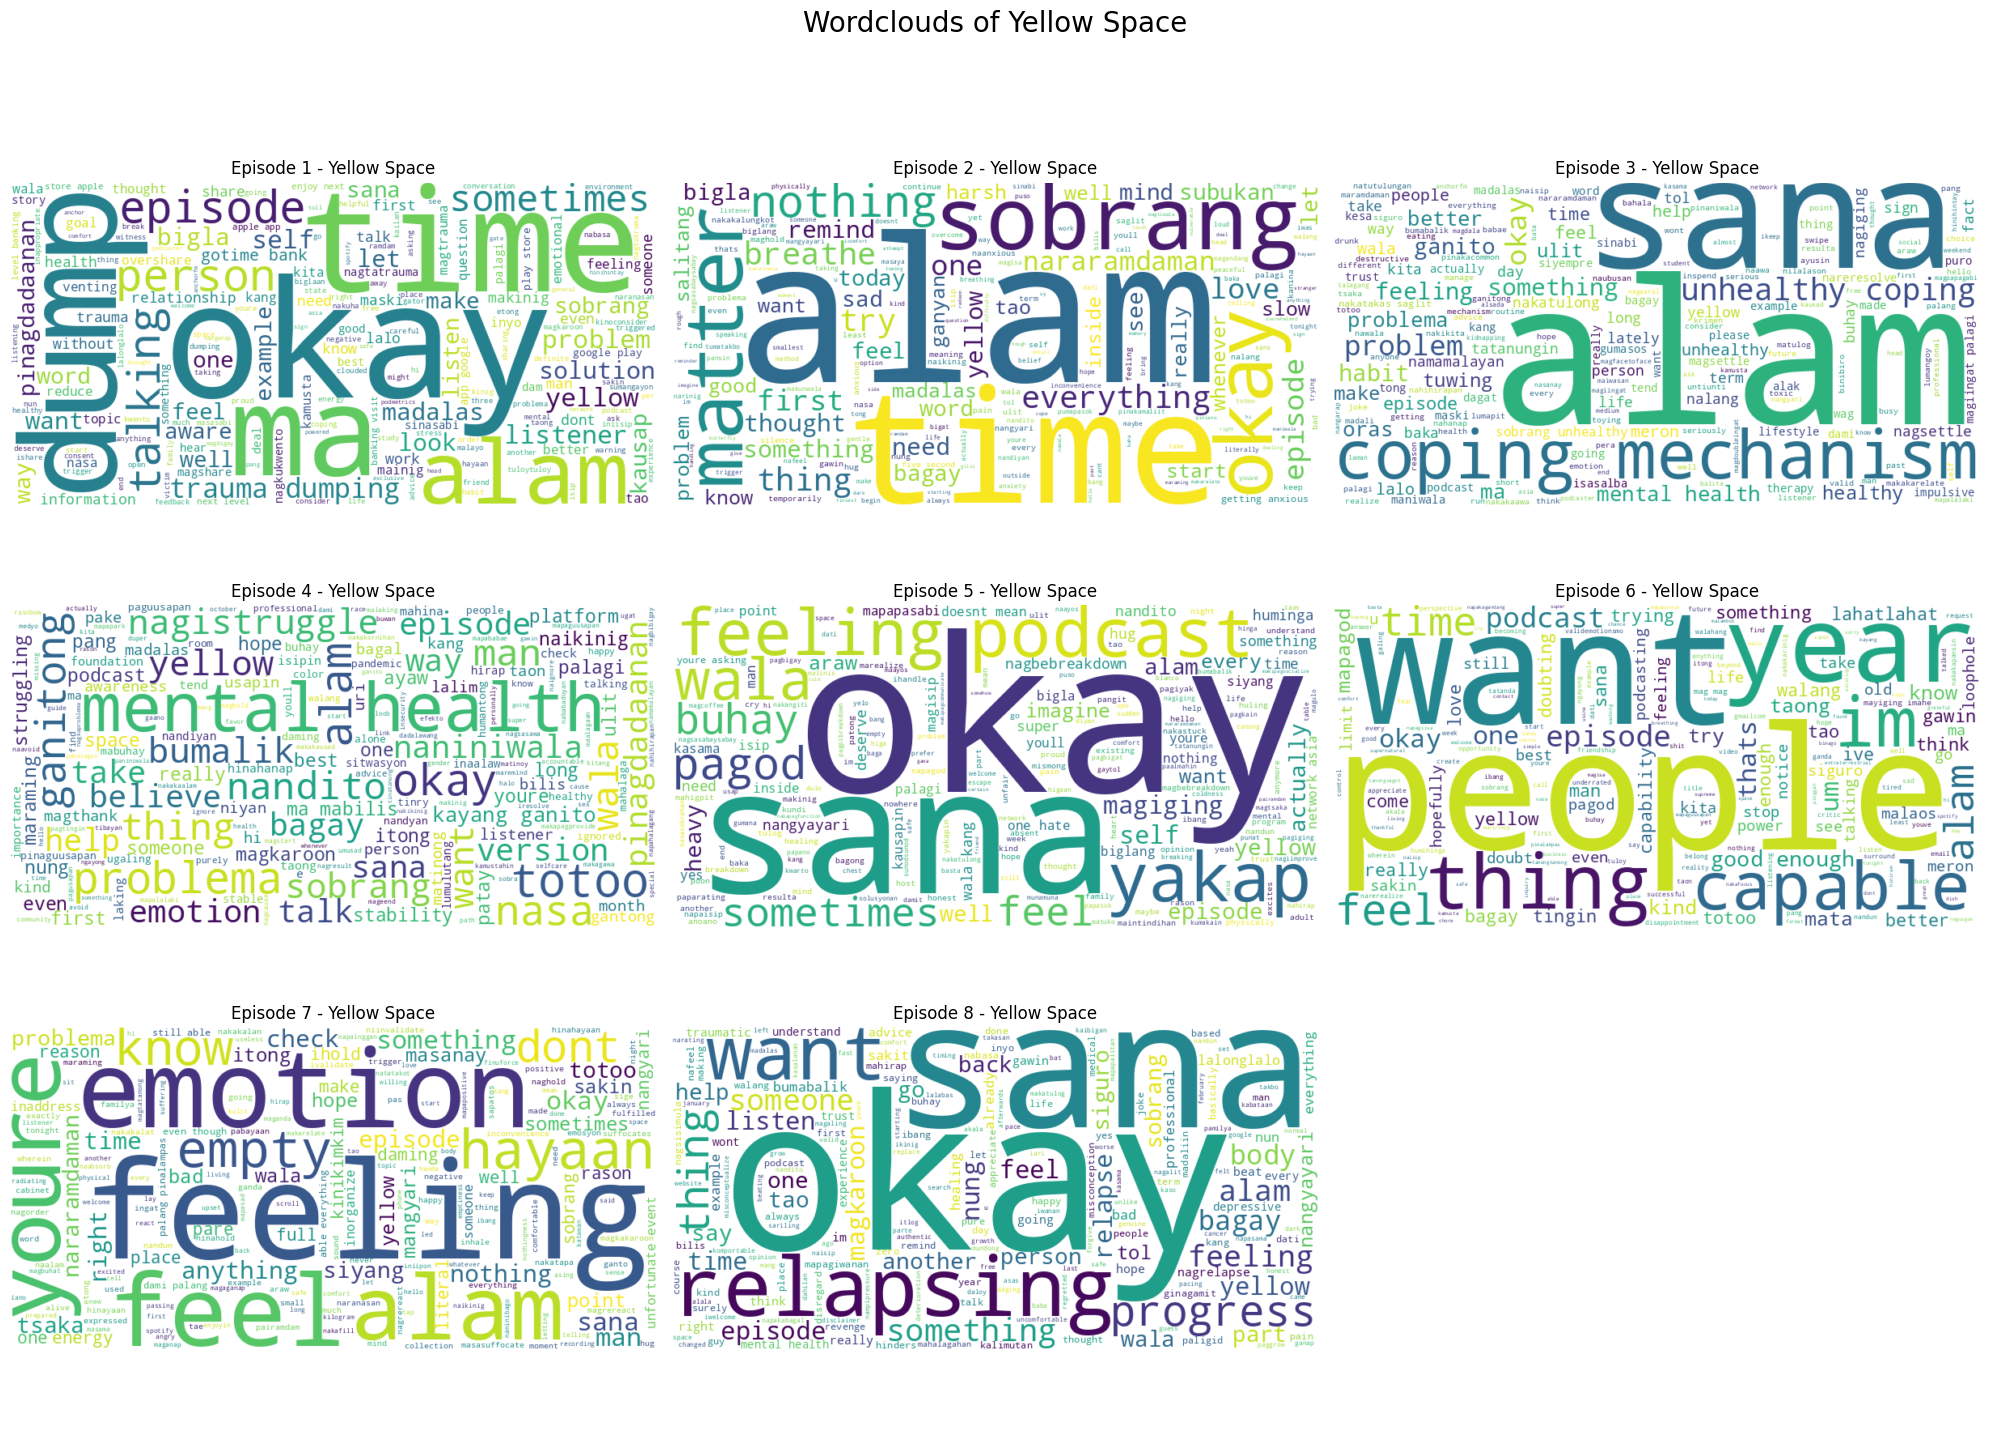

In [ ]:
# Define directories for text files
directories = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Define English stopwords
english_stopwords = set(stopwords.words('english'))

# Load Tagalog stopwords from file
tagalog_stopwords_file = "/content/drive/MyDrive/Thesis Data/stopwords-tl.txt"
with open(tagalog_stopwords_file, 'r') as f:
    tagalog_stopwords = set(f.read().splitlines())

# Combine English and Tagalog stopwords
all_stopwords = english_stopwords.union(tagalog_stopwords)

# Function to read files from a directory
def read_files_from_directory(directory):
    corpus = []
    for file in sorted(os.listdir(directory)):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            text = f.read()
            corpus.append(text)
    return corpus

# Function to lemmatize words
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(word) for word in words]
    return lemma_words

# Function to preprocess the corpus
def preprocess_corpus(corpus, stopwords):
    processed_corpus = []
    for document in corpus:
        cleaned_text = re.sub(r'[^a-zA-Z\s]', '', document.lower())
        words = word_tokenize(cleaned_text)
        filtered_words = [word for word in words if word not in stopwords]
        lemmatized_words = lemmatize_words(filtered_words)
        processed_text = ' '.join(lemmatized_words)
        processed_corpus.append(processed_text)
    return processed_corpus

# Function to generate and display a word cloud
def generate_wordcloud(text, title, ax):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title)
    ax.axis('off')

# Read, preprocess and generate word cloud for each episode in each directory
for directory, podcast_title in zip(directories, ["Mind Buddies", "Podcassie on Healthy Mentality", "Yellow Space"]):
    # Read files
    corpus = read_files_from_directory(directory)

    # Preprocess corpus
    processed_corpus = preprocess_corpus(corpus, all_stopwords)

    # Determine subplot layout
    num_episodes = len(processed_corpus)
    ncols = 3
    nrows = (num_episodes // ncols) + (num_episodes % ncols > 0)

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 5))

    # Generate word cloud for each episode
    for i, episode in enumerate(processed_corpus):
        row, col = divmod(i, ncols)
        ax = axes[row, col] if nrows > 1 else axes[col]
        title = f"Episode {i + 1} - {podcast_title}"
        generate_wordcloud(episode, title, ax)

    # Hide any empty subplots
    for j in range(num_episodes, nrows * ncols):
        row, col = divmod(j, ncols)
        ax = axes[row, col] if nrows > 1 else axes[col]
        ax.axis('off')

    plt.suptitle(f"Wordclouds of {podcast_title}", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# Define directories for text files
directories = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Read and combine text files from directories into one corpus
def read_combine_files(directories):
    corpus = []
    for directory in directories:
        files = os.listdir(directory)
        for file in files:
            file_path = os.path.join(directory, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                corpus.append(text)
    return corpus

# Function to lemmatize words
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

# Preprocess the corpus by removing stopwords and lemmatizing
def preprocess_corpus(corpus, stopwords):
    processed_corpus = []
    for document in corpus:
        cleaned_text = re.sub(r'[^a-zA-Z\s]', '', document.lower())
        words = word_tokenize(cleaned_text)
        filtered_words = [word for word in words if word not in stopwords]
        lemmatized_words = lemmatize_words(filtered_words)
        processed_corpus.append(lemmatized_words)  # Changed to append list of words
    return processed_corpus

# Read and combine text files from directories into corpus
corpus = read_combine_files(directories)

# Define stopwords in English and Tagalog
english_stopwords = set(stopwords.words('english'))
tagalog_stopwords = set(tagalog_stopwords)
all_stopwords = english_stopwords.union(tagalog_stopwords)

# Preprocess the corpus by removing stopwords
processed_corpus = preprocess_corpus(corpus, all_stopwords)

# Print the first few processed documents to verify
print(processed_corpus[:2])

# Create a dictionary from the tokenized corpus
dictionary = corpora.Dictionary(processed_corpus)

# Create a bag-of-words representation of the corpus
corpus_bow = [dictionary.doc2bow(document) for document in processed_corpus]

# Ensure that corpus_bow contains 21 documents
print(f'Number of documents in corpus_bow: {len(corpus_bow)}')

# Check the first document's bag-of-words representation
print(corpus_bow[0])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[['hmm', 'hello', 'everyone', 'ganda', 'topic', 'mahirap', 'mahalin', 'totoo', 'mahirapan', 'mahalin', 'mahalin', 'mere', 'fact', 'nandito', 'nagiexist', 'kamahalmahal', 'ganon', 'mahirap', 'mahalin', 'welcome', 'mind', 'buddy', 'millennial', 'psychologist', 'rian', 'portuguese', 'service', 'siyempre', 'siyempre', 'nagtanong', 'nung', 'nakaraan', 'mahirap', 'mahalin', 'ifeature', 'listener', 'napakainteresting', 'sagot', 'naghalohalo', 'tema', 'siyempre', 'imemention', 'tema', 'nakuha', 'audience', 'alam', 'makakarelate', 'maiba', 'tema', 'sagot', 'kinalaman', 'condition', 'worth', 'maiba', 'pagbibigay', 'atensyon', 'maiba', 'pagkafroy', 'desire', 'namang', 'kinalaman', 'pagkukumpara', 'simulan', 'meron', 'talagang', 'naganswer', 'mahirap', 'daw', 'mahalin', 'keji', 'dinedepende', 'worth', 'standard', 'mahirap', 'habulin', 'ideal', 'sineset', 'naisip', 'order', 'worthy', 'must', 'please', 'people', 'feed', 'ego', 'mahal', 'feel', 'worthy', 'nagsastart', 'pagmamahal', 'well', 'fact', 'f

In [ ]:
print("Type of corpus (BoW matrix):", type(processed_corpus))
print("Type of BoW for the first document:", type(tokens))
print("Type of a document:", type(corpus_bow))
print("Type of a Dictionary:", type(dictionary))

Type of corpus (BoW matrix): <class 'list'>
Type of BoW for the first document: <class 'list'>
Type of a document: <class 'list'>
Type of a Dictionary: <class 'gensim.corpora.dictionary.Dictionary'>


#### LDA

In [ ]:
# Check the number of documents
num_docs = len(corpus_bow)
print(f'Number of documents in corpus: {num_docs}')

Number of documents in corpus: 21


Fold: 1, Epoch: 1, Passes: 5, Perplexity: -12.356547869839183


Fold: 1, Epoch: 2, Passes: 5, Perplexity: -12.633470674718952


Fold: 1, Epoch: 3, Passes: 5, Perplexity: -12.881905742410416


Fold: 1, Epoch: 4, Passes: 5, Perplexity: -13.08362858987074


Fold: 1, Epoch: 5, Passes: 5, Perplexity: -13.252031728037606


Fold: 1, Epoch: 6, Passes: 5, Perplexity: -13.396009725120118


Fold: 1, Epoch: 7, Passes: 5, Perplexity: -13.522048003335764


Fold: 1, Epoch: 8, Passes: 5, Perplexity: -13.633800735410727


Fold: 1, Epoch: 9, Passes: 5, Perplexity: -13.734493412420418


Fold: 1, Epoch: 10, Passes: 5, Perplexity: -13.825638575984405


Fold: 2, Epoch: 1, Passes: 5, Perplexity: -12.237784633353904


Fold: 2, Epoch: 2, Passes: 5, Perplexity: -12.57035436354743


Fold: 2, Epoch: 3, Passes: 5, Perplexity: -12.853608943797925


Fold: 2, Epoch: 4, Passes: 5, Perplexity: -13.079304870958682


Fold: 2, Epoch: 5, Passes: 5, Perplexity: -13.267306491922449


Fold: 2, Epoch: 6, Passes: 5, Perplexity: -13.428092694317852


Fold: 2, Epoch: 7, Passes: 5, Perplexity: -13.569169924700702


Fold: 2, Epoch: 8, Passes: 5, Perplexity: -13.69345287739789


Fold: 2, Epoch: 9, Passes: 5, Perplexity: -13.806128997308237


Fold: 2, Epoch: 10, Passes: 5, Perplexity: -13.90836265344973


Fold: 3, Epoch: 1, Passes: 5, Perplexity: -12.245031796329474


Fold: 3, Epoch: 2, Passes: 5, Perplexity: -12.524335254914265


Fold: 3, Epoch: 3, Passes: 5, Perplexity: -12.758792381409856


Fold: 3, Epoch: 4, Passes: 5, Perplexity: -12.948373720324158


Fold: 3, Epoch: 5, Passes: 5, Perplexity: -13.107135700682496


Fold: 3, Epoch: 6, Passes: 5, Perplexity: -13.243105335670405


Fold: 3, Epoch: 7, Passes: 5, Perplexity: -13.361977988127657


Fold: 3, Epoch: 8, Passes: 5, Perplexity: -13.46853898935575


Fold: 3, Epoch: 9, Passes: 5, Perplexity: -13.56497573259617
Fold: 3, Epoch: 10, Passes: 5, Perplexity: -13.653005527255448


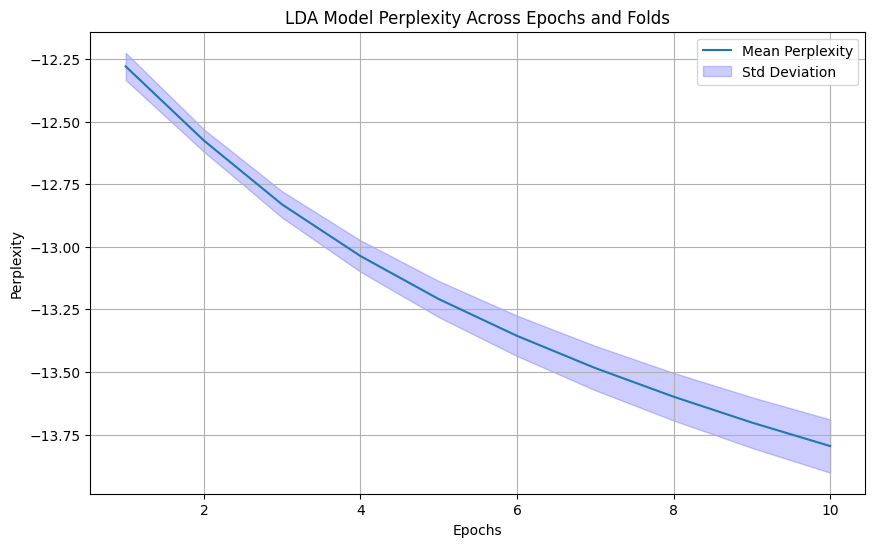

In [ ]:
import numpy as np
from gensim.models import LdaModel
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Assuming corpus_bow and dictionary are already defined
num_topics = 10
num_folds = 3
num_epochs = 10
num_passes_per_epoch = 5  # Set the number of passes per epoch

kf = KFold(n_splits=num_folds, shuffle=True, random_state=10)

perplexity_scores = np.zeros((num_folds, num_epochs))

for fold, (train_index, val_index) in enumerate(kf.split(corpus_bow)):
    train_corpus = [corpus_bow[i] for i in train_index]
    val_corpus = [corpus_bow[i] for i in val_index]

    lda_model = LdaModel(corpus=train_corpus, id2word=dictionary, num_topics=num_topics, random_state=10, passes=1)

    for epoch in range(num_epochs):
        lda_model.update(train_corpus, passes=num_passes_per_epoch)  # Increase the number of passes
        perplexity = lda_model.log_perplexity(val_corpus)
        perplexity_scores[fold, epoch] = perplexity
        print(f'Fold: {fold+1}, Epoch: {epoch+1}, Passes: {num_passes_per_epoch}, Perplexity: {perplexity}')

# Visualization
mean_perplexity = np.mean(perplexity_scores, axis=0)
std_perplexity = np.std(perplexity_scores, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), mean_perplexity, label='Mean Perplexity')
plt.fill_between(range(1, num_epochs + 1),
                 mean_perplexity - std_perplexity,
                 mean_perplexity + std_perplexity,
                 color='b', alpha=0.2, label='Std Deviation')

plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('LDA Model Perplexity Across Epochs and Folds')
plt.legend()
plt.grid(True)
plt.show()

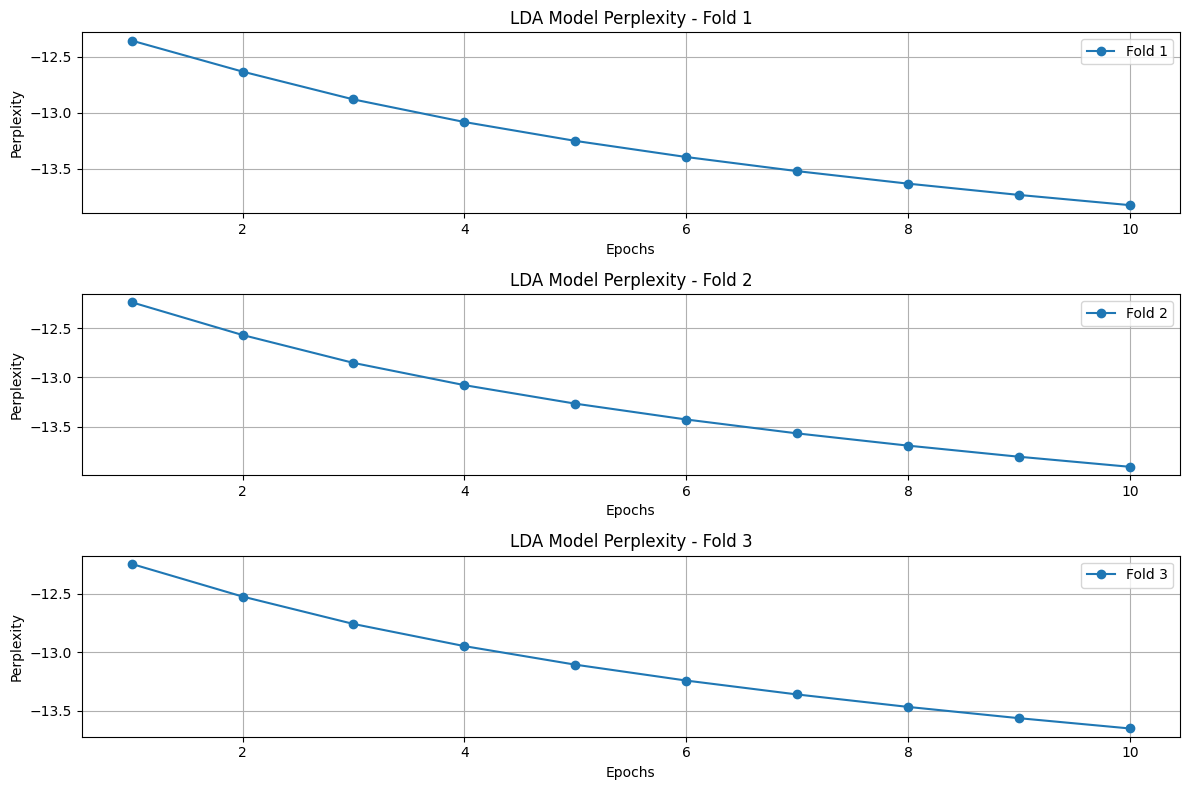

In [ ]:
# Visualize perplexity for each fold separately
plt.figure(figsize=(12, 8))

for fold in range(num_folds):
    plt.subplot(num_folds, 1, fold+1)
    plt.plot(range(1, num_epochs + 1), perplexity_scores[fold], marker='o', linestyle='-', label=f'Fold {fold+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.title(f'LDA Model Perplexity - Fold {fold+1}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# COHERENCE SCORE CALCULATION

from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_corpus, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()

print(f'Coherence Score: {coherence_score}')

Coherence Score: 0.39344993380044535


In [ ]:
# TOPIC FREQUENCY
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx}\nWords: {topic}\n')

Topic: 0
Words: 0.010*"feel" + 0.009*"birthday" + 0.009*"like" + 0.008*"get" + 0.008*"youre" + 0.008*"dont" + 0.008*"sleep" + 0.008*"want" + 0.008*"people" + 0.007*"think"

Topic: 1
Words: 0.000*"letting" + 0.000*"kanta" + 0.000*"mako" + 0.000*"makapagpatawad" + 0.000*"mahaba" + 0.000*"magrerestore" + 0.000*"magpatawad" + 0.000*"maaaalleviate" + 0.000*"marireplace" + 0.000*"laughing"

Topic: 2
Words: 0.000*"letting" + 0.000*"kanta" + 0.000*"mako" + 0.000*"makapagpatawad" + 0.000*"mahaba" + 0.000*"magrerestore" + 0.000*"magpatawad" + 0.000*"maaaalleviate" + 0.000*"marireplace" + 0.000*"laughing"

Topic: 3
Words: 0.021*"feeling" + 0.015*"feel" + 0.013*"people" + 0.013*"alam" + 0.012*"want" + 0.011*"emotion" + 0.009*"thing" + 0.009*"year" + 0.009*"know" + 0.009*"episode"

Topic: 4
Words: 0.013*"time" + 0.012*"like" + 0.011*"wwwanchorfm" + 0.011*"ocd" + 0.010*"bagay" + 0.010*"germ" + 0.009*"meron" + 0.009*"alcohol" + 0.008*"thought" + 0.007*"machine"

Topic: 5
Words: 0.024*"year" + 0.018*"

In [ ]:
# MOST UNIQUE WORDS PER TOPIC

topic_weights = lda_model.get_topics()
topic_df = pd.DataFrame(topic_weights).T

topic_word_matrix = lda_model.get_topics()
topic_word_matrix_list = topic_word_matrix.tolist()

# Dictionary to track the words that have already been selected
selected_words = set()

if isinstance(topic_word_matrix_list, list):
    print("Topic-Word Matrix (showing top 5 unique words per topic):")
    for i, topic in enumerate(topic_word_matrix_list):
        if not topic:
            print(f"Topic {i+1}: (no words)")
        else:
            sorted_word_weights = sorted(enumerate(topic), key=lambda x: x[1], reverse=True)
            unique_words = []

            for word_id, weight in sorted_word_weights:
                word = dictionary[word_id]
                if word not in selected_words:
                    unique_words.append((word, weight))
                    selected_words.add(word)

                if len(unique_words) >= 5:
                    break

            print(f"Topic {i+1}:")
            for word, weight in unique_words:
                print(f"\t- {word}: {weight:.4f}")
        print("")
else:
    print("topic_word_matrix is not a list. Investigate why the model is returning a scalar value.")

results = []

if isinstance(topic_word_matrix_list, list):
    for i, topic in enumerate(topic_word_matrix_list):
        if not topic:
            results.append([f"Topic {i+1}", "(no words)", ""])
        else:
            sorted_word_weights = sorted(enumerate(topic), key=lambda x: x[1], reverse=True)
            unique_words = []
            for word_id, weight in sorted_word_weights:
                word = dictionary[word_id]
                if word not in selected_words:
                    unique_words.append((word, weight))
                    selected_words.add(word)
                if len(unique_words) >= 5:
                    break
            for word, weight in unique_words:
                results.append([f"Topic {i+1}", word, weight])


results_df = pd.DataFrame(results, columns=["Topic", "Word", "Weight"])
results_df

Topic-Word Matrix (showing top 5 unique words per topic):
Topic 1:
	- feel: 0.0096
	- birthday: 0.0089
	- like: 0.0087
	- get: 0.0083
	- youre: 0.0082

Topic 2:
	- aamin: 0.0002
	- abangan: 0.0002
	- able: 0.0002
	- accessibility: 0.0002
	- achievement: 0.0002

Topic 3:
	- actually: 0.0002
	- adult: 0.0002
	- advantage: 0.0002
	- advocacy: 0.0002
	- akala: 0.0002

Topic 4:
	- feeling: 0.0207
	- people: 0.0132
	- alam: 0.0126
	- want: 0.0119
	- emotion: 0.0113

Topic 5:
	- time: 0.0127
	- wwwanchorfm: 0.0112
	- ocd: 0.0107
	- bagay: 0.0102
	- germ: 0.0098

Topic 6:
	- year: 0.0244
	- goal: 0.0184
	- new: 0.0184
	- resolution: 0.0184
	- let: 0.0107

Topic 7:
	- okay: 0.0169
	- sobrang: 0.0125
	- yellow: 0.0115
	- nothing: 0.0098
	- everything: 0.0081

Topic 8:
	- tao: 0.0172
	- meron: 0.0108
	- episode: 0.0101
	- wala: 0.0093
	- kang: 0.0086

Topic 9:
	- learned: 0.0205
	- helplessness: 0.0154
	- cant: 0.0144
	- also: 0.0113
	- help: 0.0092

Topic 10:
	- alamin: 0.0002
	- alimbawa: 0.000

Topic           Word    Weight
0    Topic 1           dont  0.008139
1    Topic 1          sleep  0.008139
2    Topic 1          think  0.007402
3    Topic 1      something  0.007140
4    Topic 1         siguro  0.006319
5    Topic 2          amaro  0.000199
6    Topic 2         anchor  0.000199
7    Topic 2            ann  0.000199
8    Topic 2         anoano  0.000199
9    Topic 2         answer  0.000199
10   Topic 3          apple  0.000199
11   Topic 3       approval  0.000199
12   Topic 3         around  0.000199
13   Topic 3       atensyon  0.000199
14   Topic 3       attitude  0.000199
15   Topic 4          thing  0.009419
16   Topic 4           know  0.008791
17   Topic 4         enough  0.006909
18   Topic 4            man  0.006909
19   Topic 4           sana  0.006909
20   Topic 5        alcohol  0.008779
21   Topic 5        thought  0.007804
22   Topic 5        machine  0.007316
23   Topic 5       nakaraan  0.006342
24   Topic 5            way  0.006342
25   Topic 6             go  0.008926
26   Topic 6         better  0.007736
27   Topic 6           well  0.007736
28   Topic 6            try  0.007142
29   Topic 6          taong  0.005952
30   Topic 7         matter  0.007996
31   Topic 7           self  0.007947
32   Topic 7           need  0.007192
33   Topic 7        breathe  0.007108
34   Topic 7        anxious  0.007108
35   Topic 8         magisa  0.007900
36   Topic 8          mahal  0.007900
37   Topic 8         normal  0.007183
38   Topic 8          buhay  0.006465
39   Topic 8          totoo  0.005747
40   Topic 9       optimism  0.009244
41   Topic 9       negative  0.008218
42   Topic 9        example  0.008218
43   Topic 9        control  0.006166
44   Topic 9         course  0.006166
45  Topic 10       audience  0.000199
46  Topic 10  automatically  0.000199
47  Topic 10          aware  0.000199
48  Topic 10      awareness  0.000199
49  Topic 10           away  0.000199

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary

# Ensure the previous steps are executed (corpus, dictionary, lda_model creation, etc.)

# Get the topic-word matrix
topic_word_matrix = lda_model.get_topics()

# Check the type and contents of topic_word_matrix
print(type(topic_word_matrix))

# Dictionary to track the words that have already been selected
selected_words = set()

# Check if topic_word_matrix is a numpy array (as expected)
if isinstance(topic_word_matrix, np.ndarray):
    print("Topic-Word Matrix (showing top 5 unique words per topic):")
    results = []
    for i, topic in enumerate(topic_word_matrix):
        sorted_word_weights = sorted(enumerate(topic), key=lambda x: x[1], reverse=True)
        unique_words = []

        for word_id, weight in sorted_word_weights:
            word = dictionary[word_id]
            if word not in selected_words:
                unique_words.append((word, weight))
                selected_words.add(word)

            if len(unique_words) >= 5:
                break

        print(f"Topic {i + 1}:")
        for word, weight in unique_words:
            print(f"\t- {word}: {weight:.4f}")
            results.append([f"Topic {i + 1}", word, weight])
        print("")
else:
    print("topic_word_matrix is not a numpy array. Investigate why the model is returning a scalar value.")

<class 'numpy.ndarray'>
Topic-Word Matrix (showing top 5 unique words per topic):
Topic 1:
	- feel: 0.0096
	- birthday: 0.0089
	- like: 0.0087
	- get: 0.0083
	- youre: 0.0082

Topic 2:
	- aamin: 0.0002
	- abangan: 0.0002
	- able: 0.0002
	- accessibility: 0.0002
	- achievement: 0.0002

Topic 3:
	- actually: 0.0002
	- adult: 0.0002
	- advantage: 0.0002
	- advocacy: 0.0002
	- akala: 0.0002

Topic 4:
	- feeling: 0.0207
	- people: 0.0132
	- alam: 0.0126
	- want: 0.0119
	- emotion: 0.0113

Topic 5:
	- time: 0.0127
	- wwwanchorfm: 0.0112
	- ocd: 0.0107
	- bagay: 0.0102
	- germ: 0.0098

Topic 6:
	- year: 0.0244
	- goal: 0.0184
	- new: 0.0184
	- resolution: 0.0184
	- let: 0.0107

Topic 7:
	- okay: 0.0169
	- sobrang: 0.0125
	- yellow: 0.0115
	- nothing: 0.0098
	- everything: 0.0081

Topic 8:
	- tao: 0.0172
	- meron: 0.0108
	- episode: 0.0101
	- wala: 0.0093
	- kang: 0.0086

Topic 9:
	- learned: 0.0205
	- helplessness: 0.0154
	- cant: 0.0144
	- also: 0.0113
	- help: 0.0092

Topic 10:
	- alamin: 0

In [ ]:
# Assuming lda_model is your trained LDA model

# Get the top words and their probabilities for each topic
topics = lda_model.show_topics(formatted=False)

# topics is a list of tuples (topic_number, [(word, probability), ...])
# Extracting top words and probabilities for visualization
top_words = [(topic_num, [(word, prob) for word, prob in lda_words]) for topic_num, lda_words in topics]

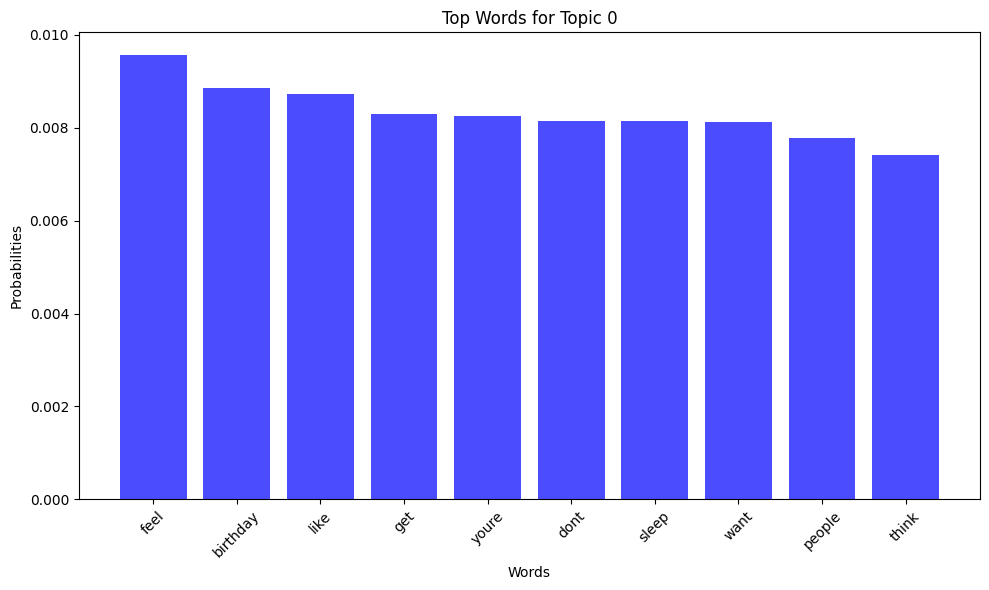

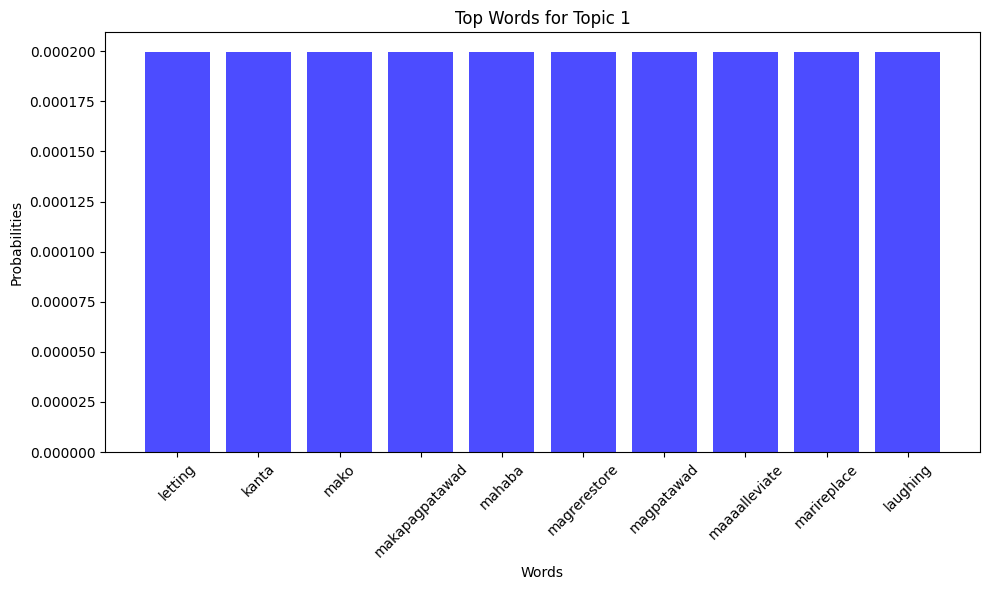

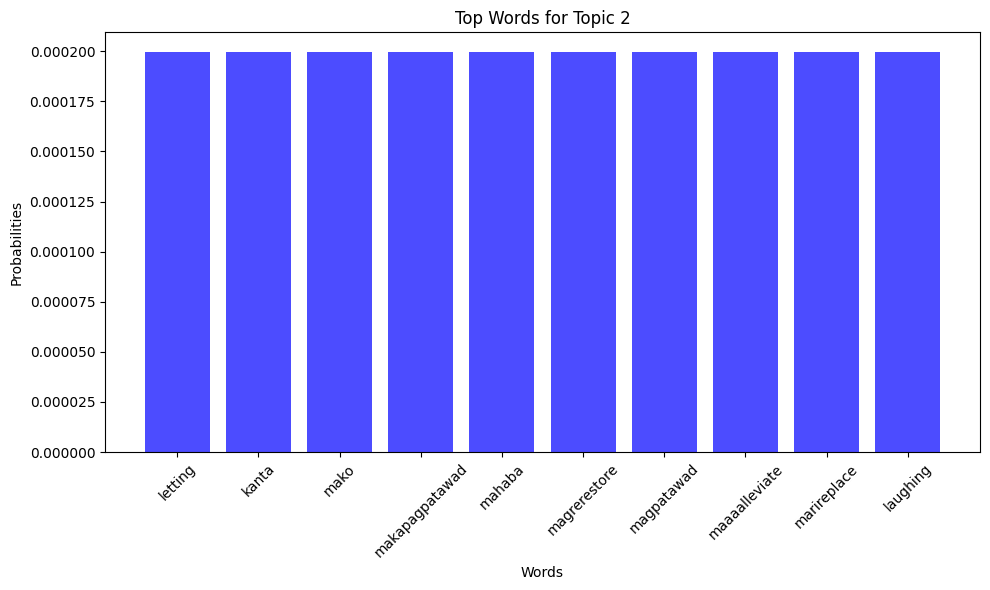

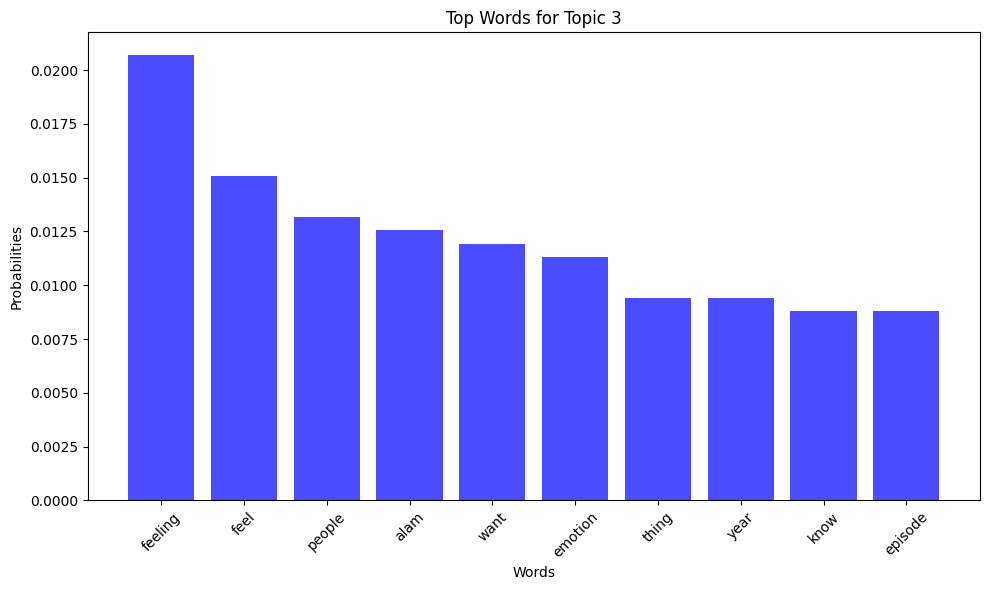

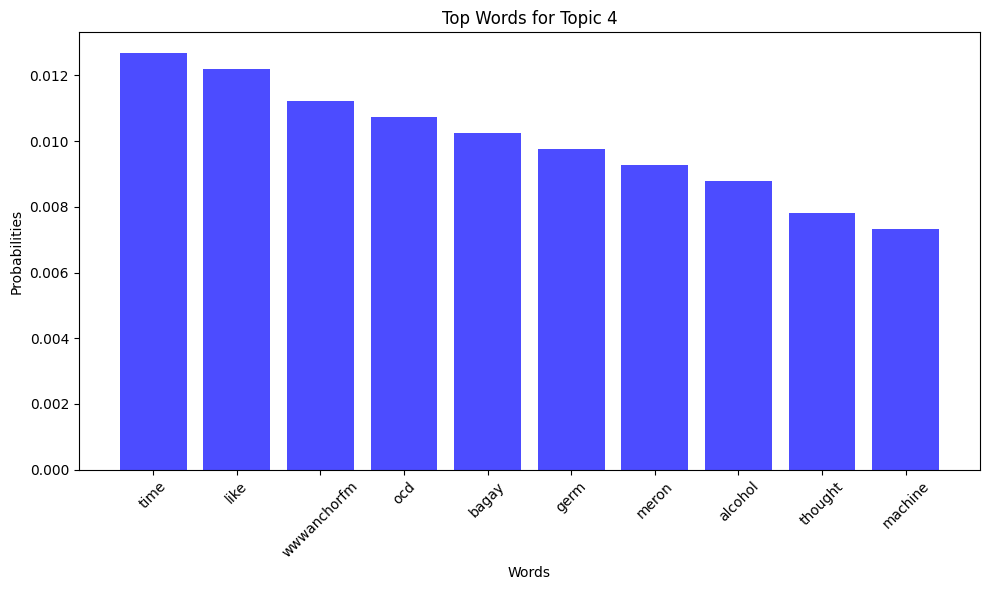

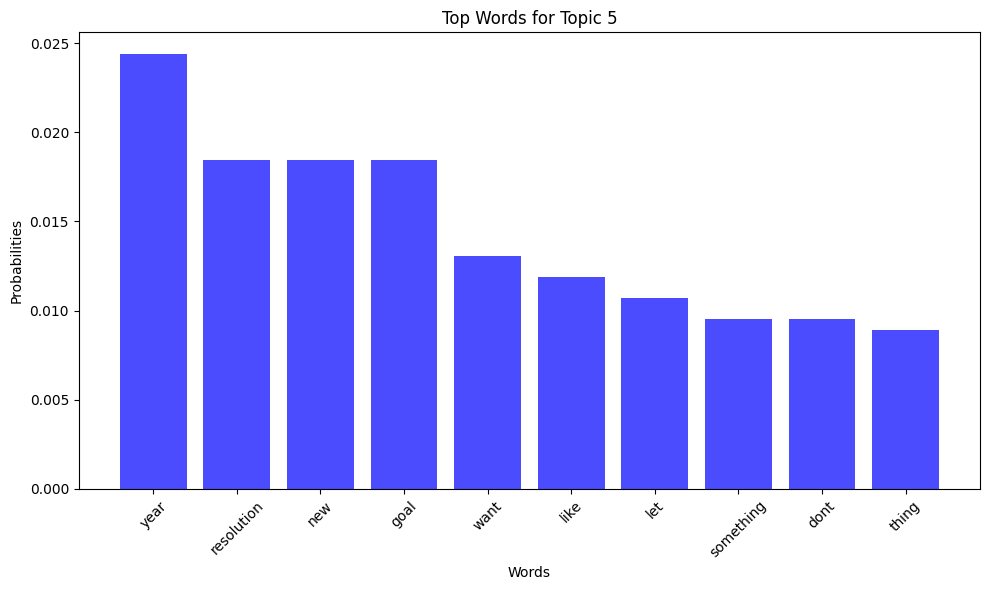

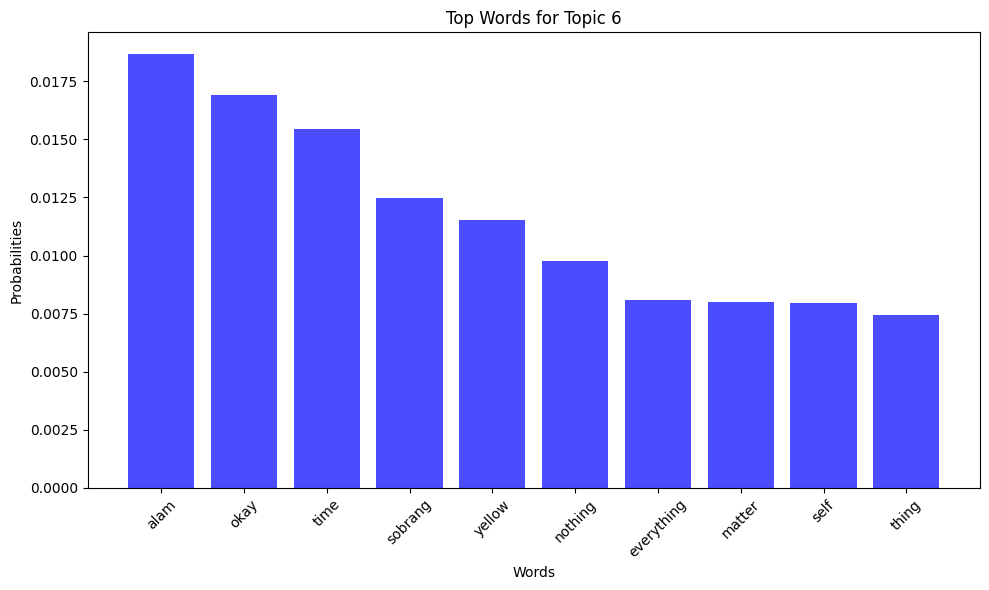

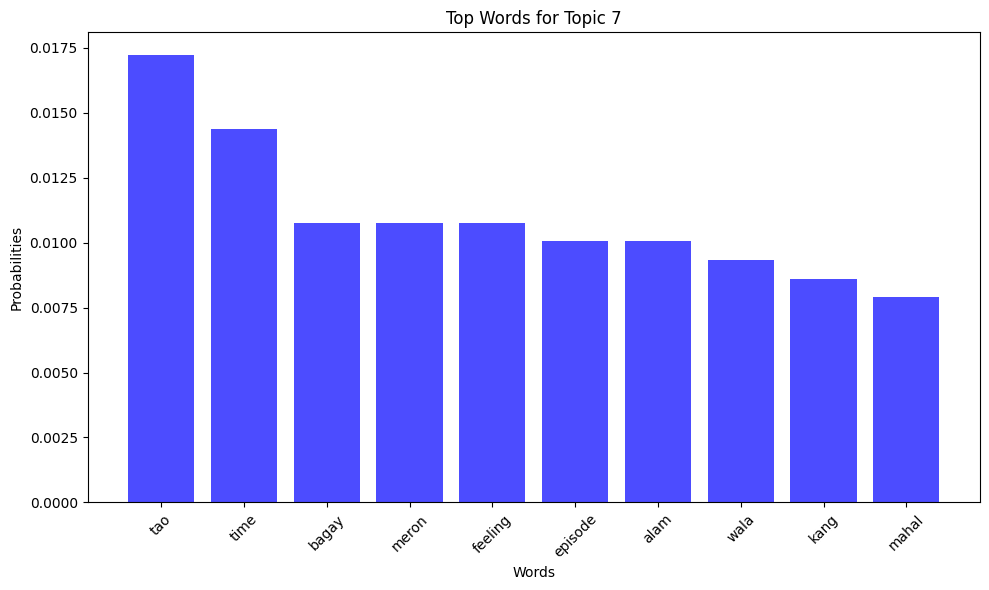

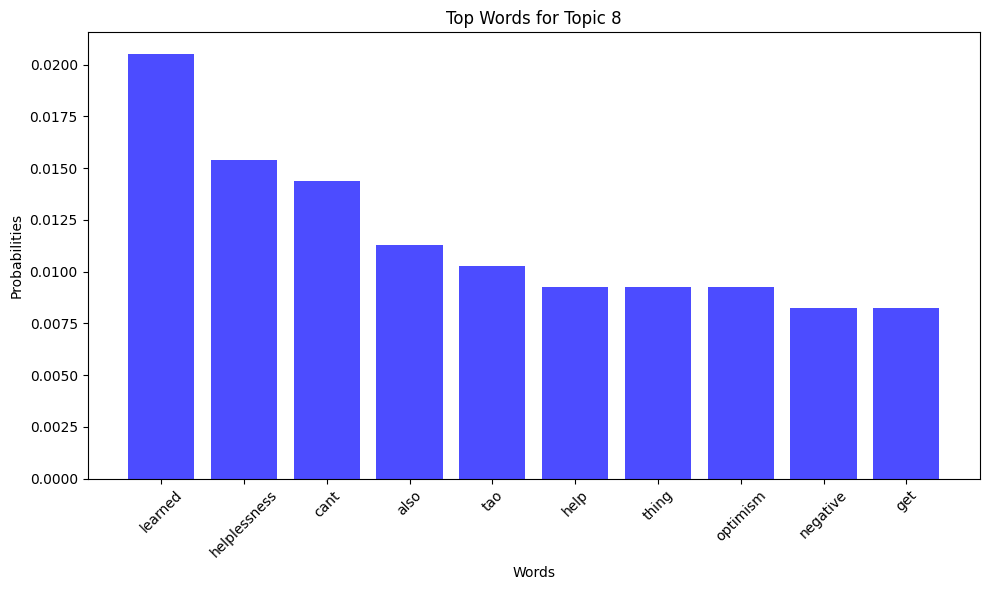

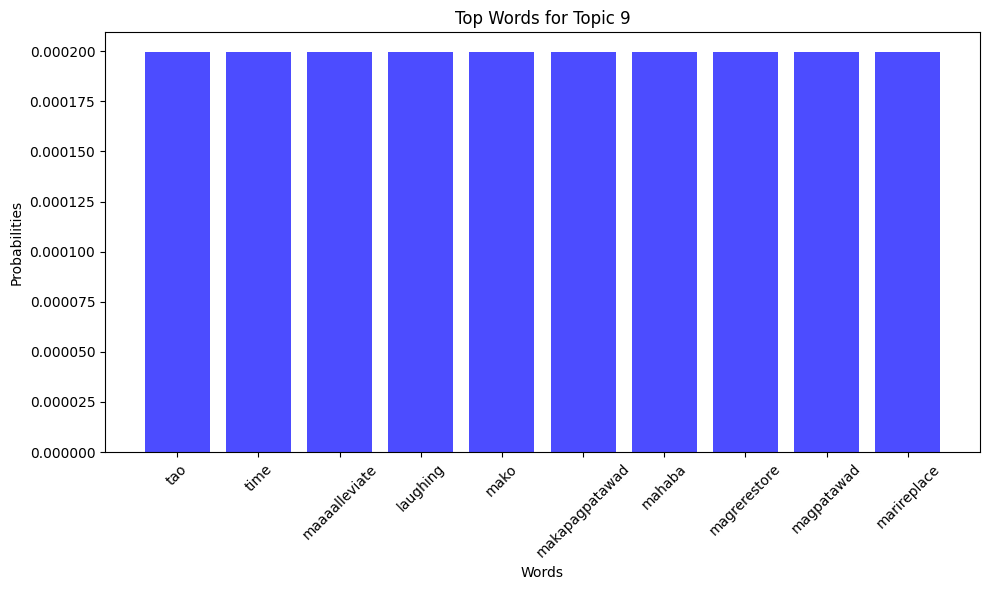

In [ ]:
import matplotlib.pyplot as plt

# Function to plot top words for a single topic
def plot_topic_words(topic_num, top_words):
    words = [word for word, prob in top_words]
    probs = [prob for word, prob in top_words]

    plt.figure(figsize=(10, 6))
    plt.bar(words, probs, color='blue', alpha=0.7)
    plt.xlabel('Words')
    plt.ylabel('Probabilities')
    plt.title(f'Top Words for Topic {topic_num}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot top words for each topic
for topic_num, words_probs in top_words:
    plot_topic_words(topic_num, words_probs)

#### BERTopic

In [ ]:
# Join tokens back into documents
documents = [' '.join(doc) for doc in tokens]

In [ ]:
# Initialize BERTopic model components and parameters
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=15, min_samples=5, gen_min_span_tree=True, prediction_data=True)

# Building the BERTopic model
model = BERTopic(embedding_model=embedding_model,
                 umap_model=umap_model,
                 hdbscan_model=hdbscan_model,
                 top_n_words=5,
                 calculate_probabilities=True,
                 verbose=True)

In [ ]:
num_folds = 3  # Number of folds
num_epochs = 10  # Number of epochs per fold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=10)

# Store coherence scores
coherence_scores = np.zeros((num_folds, num_epochs))

In [ ]:
print(coherence_scores)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
# Define directories for text files
directories = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Read and combine text files from directories into one corpus
def read_combine_files(directories):
    corpus = []
    for directory in directories:
        files = os.listdir(directory)
        for file in files:
            file_path = os.path.join(directory, file)
            with open(file_path, 'r') as f:
                text = f.read()
                corpus.append(text)
    return corpus

# Function to lemmatize words based on their POS tag
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemma_words = []
    for word in words:
        lemma_words.append(lemmatizer.lemmatize(word))
    return lemma_words

# Preprocess the corpus by removing stopwords and lemmatizing
def preprocess_corpus(corpus, stopwords):
    processed_corpus = []
    for document in corpus:
        # Remove non-alphanumeric characters and convert to lowercase
        cleaned_text = re.sub(r'[^a-zA-Z\s]', '', document.lower())
        # Tokenize the text
        # Import word_tokenize from nltk
        from nltk.tokenize import word_tokenize
        words = word_tokenize(cleaned_text)
        # Remove stopwords in English and Tagalog
        filtered_words = [word for word in words if word not in stopwords]
        # Lemmatize the words
        lemmatized_words = lemmatize_words(filtered_words)
        # Join lemmatized words back into a string
        processed_text = ' '.join(lemmatized_words)
        processed_corpus.append(processed_text)
    return processed_corpus

# Tokenize the processed corpus
def tokenize_corpus(processed_corpus):
    tokens = []
    for document in processed_corpus:
        tokens.extend(document.split())
    return tokens

# Read and combine text files from directories into corpus
corpus = read_combine_files(directories)

# Preprocess the corpus by removing stopwords
processed_corpus = preprocess_corpus(corpus, all_stopwords)

# Tokenize the processed corpus
tokens = tokenize_corpus(processed_corpus)

# Print the first few characters of the combined corpus to verify
print(processed_corpus[:500])

# Create a dictionary from the tokenized corpus
dictionary = corpora.Dictionary([tokens])

# Create a bag-of-words representation of the corpus
corpus_bow = [dictionary.doc2bow(tokens)]

['hmm hello everyone ganda topic mahirap mahalin totoo mahirapan mahalin mahalin mere fact nandito nagiexist kamahalmahal ganon mahirap mahalin welcome mind buddy millennial psychologist rian portuguese service siyempre siyempre nagtanong nung nakaraan mahirap mahalin ifeature listener napakainteresting sagot naghalohalo tema siyempre imemention tema nakuha audience alam makakarelate maiba tema sagot kinalaman condition worth maiba pagbibigay atensyon maiba pagkafroy desire namang kinalaman pagkukumpara simulan meron talagang naganswer mahirap daw mahalin keji dinedepende worth standard mahirap habulin ideal sineset naisip order worthy must please people feed ego mahal feel worthy nagsastart pagmamahal well fact first place validation love desire must came alam katotohanan sinabi time akala talagang mahal alam source love nagagaling ibang tao teka wala namang masama source love nagagaling ibang tao psychology fact pinaguusapan teorya mahalaga mabuild foundation love trust pang essentia

In [ ]:
# Initialize BERTopic model
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

# If CUDA is available, try setting the device to CPU
device = torch.device('cpu')

# Load the RoBERTa Tagalog model on the selected device
embedding_model = SentenceTransformer("jcblaise/roberta-tagalog-base", device=device)

# Get the maximum sequence length for the model
max_seq_length = embedding_model.max_seq_length
print(f"Maximum sequence length for the model: {max_seq_length}")

# Initialize BERTopic with the embedding model and adjusted HDBSCAN parameters
topic_model = BERTopic(
    embedding_model=embedding_model,
    low_memory=True,
    umap_model=UMAP(init="random"),  # Change initialization to avoid spectral layout
    hdbscan_model=HDBSCAN(min_cluster_size=20, min_samples=5) # Adjust HDBSCAN parameters
)

# Fit BERTopic model with your tokenized data
topics, probabilities = topic_model.fit_transform(tokens)

# Get topic information
topic_info = topic_model.get_topic_info()

CUDA available: False
Number of GPUs: 0


Some weights of RobertaModel were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Maximum sequence length for the model: 514


In [ ]:
topic_info

Topic  Count                                          Name  \
0       -1   2069                 -1_oras_social_sasabihin_asia   
1        0    224                         0_ego_anger_got_clean   
2        1    187                       1_okay_took_haday_delay   
3        2    182                                     2_alam___   
4        3    181                    3_time_game_natural_linggo   
..     ...    ...                                           ...   
450    449     20       449_helplessness_helpless_selfkindness_   
451    450     20               450_advice_service_description_   
452    451     20                         451_there_therefore__   
453    452     20  452_resentment_adjustment_lavender_indicates   
454    453     20                                   453_much___   

                                        Representation  \
0    [oras, social, sasabihin, asia, pakiramdam, sa...   
1    [ego, anger, got, clean, char, imagine, stay, ...   
2               [okay, took, haday, delay, , , , , , ]   
3                             [alam, , , , , , , , , ]   
4            [time, game, natural, linggo, , , , , , ]   
..                                                 ...   
450  [helplessness, helpless, selfkindness, , , , ,...   
451       [advice, service, description, , , , , , , ]   
452                 [there, therefore, , , , , , , , ]   
453  [resentment, adjustment, lavender, indicates, ...   
454                           [much, , , , , , , , , ]   

                            Representative_Docs  
0                            [oras, oras, oras]  
1                               [ego, ego, ego]  
2                            [okay, okay, okay]  
3                            [alam, alam, alam]  
4                            [time, time, time]  
..                                          ...  
450  [helplessness, helplessness, helplessness]  
451                    [advice, advice, advice]  
452                       [there, there, there]  
453        [resentment, adjustment, resentment]  
454                          [much, much, much]  

[455 rows x 5 columns]

In [ ]:
topic_freq = topic_model.get_topic_freq()
topic_freq

Topic  Count
1       -1   2069
56       0    224
157      1    187
33       2    182
67       3    181
..     ...    ...
356    449     20
21     450     20
132    451     20
30     452     20
352    453     20

[455 rows x 2 columns]

In [ ]:
# Topic Frequency | With representation labels

# Get the frequency of all topics
topic_freq = topic_model.get_topic_freq()

# Sort topics by frequency in descending order
sorted_topics = topic_freq.sort_values("Count", ascending=False)

# Print topics with at least 10 words
for index, row in sorted_topics.iterrows():
    topic_idx = row['Topic']
    count = row['Count']
    topic_words = topic_model.get_topic(topic_idx)
    if len(topic_words) >= 10:  # Check if topic has at least 10 words
        top_words = [word for word, _ in topic_words]
        print(f"Topic {topic_idx}: Count: {count}, Top words: {' '.join(top_words)}")

Topic -1: Count: 2069, Top words: oras social sasabihin asia pakiramdam sakin youve strong um nalang
Topic 0: Count: 224, Top words: ego anger got clean char imagine stay cope bigyan iyak
Topic 1: Count: 187, Top words: okay took haday delay      
Topic 2: Count: 182, Top words: alam         
Topic 3: Count: 181, Top words: time game natural linggo      
Topic 4: Count: 162, Top words: tao         
Topic 5: Count: 159, Top words: like halo        
Topic 6: Count: 149, Top words: lalim lungkot kaalaman malinaw malalaman larawan daily malalim lipunan lumapit
Topic 7: Count: 138, Top words: thing lot black screen dog cover ikain   
Topic 8: Count: 138, Top words: wala struggle nagistruggle struggling      
Topic 9: Count: 131, Top words: feel model papel lumelevel azel     
Topic 10: Count: 131, Top words: feeling         
Topic 11: Count: 128, Top words: episode pangepisode        
Topic 12: Count: 125, Top words: term instagram affect subukan desire safe discus samahan arawaraw tired
To

`NOTES`: Itong part na to hindi ko sure paano gagawan ng visualization kasi madami sdjfh

In [ ]:
# VISUALIZATION | TOPIC DISTANCE PLOT

import plotly.express as px

# Reduce dimensionality of embeddings for visualization (adjust n_components as needed)
reduced_embeddings = UMAP(n_components=2, random_state=42).fit_transform(topic_model.topic_embeddings_)

# Create a DataFrame for plotting
plot_df = topic_model.get_topic_info()
plot_df['x'] = reduced_embeddings[:, 0]
plot_df['y'] = reduced_embeddings[:, 1]

# Create the distance plot using Plotly
fig = px.scatter(plot_df, x='x', y='y', hover_name='Name',
                 size='Count', color='Topic',
                 title='Topic Distance Plot (BERTopic)')

fig.update_layout(
    width=800,  # Set the width of the plot
    height=600,  # Set the height of the plot
    font=dict(size=12),  # Adjust font size if needed
    title_font_size=20,  # Adjust title font size
    legend=dict(
        font=dict(size=12),  # Adjust legend font size
    )
)

fig.show()

In [ ]:
# PYLDAVIS | BAR CHART

topic_model.visualize_barchart()

### Sentiment Analysis

In [ ]:
# SENTIMENT ANALYSIS

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import matplotlib.pyplot as plt
import numpy as np

# Load RoBERTa Tagalog model for sentiment analysis
tokenizer = AutoTokenizer.from_pretrained("jcblaise/roberta-tagalog-large")
model = AutoModelForSequenceClassification.from_pretrained("jcblaise/roberta-tagalog-large")

# Load sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Define a label mapping
label_mapping = {
"LABEL_0": "NEGATIVE",
    "LABEL_1": "POSITIVE",
}
# Example function to process and analyze sentiment for longer texts
def process_and_analyze_sentiment(text, max_length=512):
    sentiment_results = []
    text_segments = [text[i:i + max_length] for i in range(0, len(text), max_length)]
    for segment in text_segments:
        segment_sentiment = sentiment_analyzer(segment)
        for sentiment in segment_sentiment:
            # Map the label to human-readable form
            sentiment['label'] = label_mapping[sentiment['label']]
        sentiment_results.extend(segment_sentiment)
    return sentiment_results

# Perform sentiment analysis for each processed document in processed_corpus
sentiment_results = []
for document in processed_corpus:
    sentiment_results.extend(process_and_analyze_sentiment(document))

for result in sentiment_results:
    print(result)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'label': 'POSITIVE', 'score': 0.5230403542518616}
{'label': 'NEGATIVE', 'score': 0.5695138573646545}
{'label': 'NEGATIVE', 'score': 0.5507617592811584}
{'label': 'POSITIVE', 'score': 0.5281769037246704}
{'label': 'NEGATIVE', 'score': 0.5632163286209106}
{'label': 'NEGATIVE', 'score': 0.5952962040901184}
{'label': 'NEGATIVE', 'score': 0.5317369699478149}
{'label': 'NEGATIVE', 'score': 0.5382558107376099}
{'label': 'NEGATIVE', 'score': 0.5362955927848816}
{'label': 'NEGATIVE', 'score': 0.5531048774719238}
{'label': 'NEGATIVE', 'score': 0.5436918139457703}
{'label': 'NEGATIVE', 'score': 0.5170359015464783}
{'label': 'NEGATIVE', 'score': 0.5261266231536865}
{'label': 'NEGATIVE', 'score': 0.5180299878120422}
{'label': 'NEGATIVE', 'score': 0.5091162323951721}
{'label': 'NEGATIVE', 'score': 0.559978723526001}
{'label': 'NEGATIVE', 'score': 0.5847130417823792}
{'label': 'NEGATIVE', 'score': 0.5211620330810547}
{'label': 'NEGATIVE', 'score': 0.5329415798187256}
{'label': 'NEGATIVE', 'score': 0

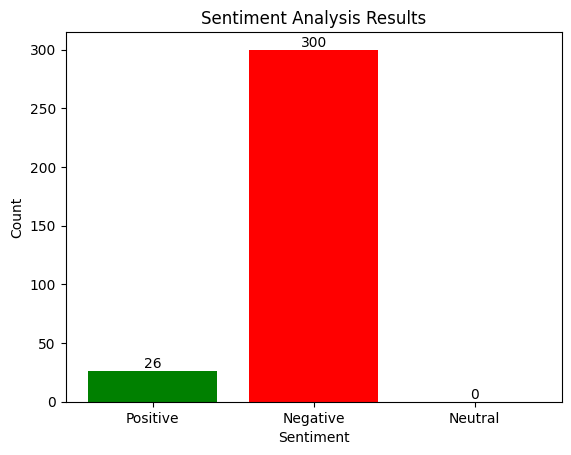

In [ ]:
# VISUALIZATION

# Initialize counters for positive, negative, and neutral sentiments
positive_count = 0
negative_count = 0
neutral_count = 0

# Classify sentiment results into positive, negative, and neutral
for result in sentiment_results:
    label = result['label']
    if label == 'POSITIVE':
        positive_count += 1
    elif label == 'NEGATIVE':
        negative_count += 1
    elif label == 'NEUTRAL':
        neutral_count += 1

# Plotting the sentiment distribution
labels = ['Positive', 'Negative', 'Neutral']
counts = [positive_count, negative_count, neutral_count]

fig, ax = plt.subplots()
bars = ax.bar(labels, counts, color=['green', 'red', 'blue'])

# Add labels and title
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
ax.set_title('Sentiment Analysis Results')

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, yval, ha='center', va='bottom')

plt.show()

`NOTES` : Puro negative translation ni Podcast data. Probably kasi hindi niya amdetect yung ibang sentiment ng Taglish jargon-- kaya maybe na-classify as Negative agad.  

Another theory I have is since trained to from a RoBERTa model in Tagalog, it might be a real conclusion na negative nga lahat ng sentiments ng podcasts. It's not entirely wrong, It can make sense.

In [ ]:
# TOPIC TAGGING INCLUDED

from transformers import AutoModelForSequenceClassification

def get_topic_distribution(text):
    # Assuming lda_model and corpus_bow are defined elsewhere
    bow = lda_model.id2word.doc2bow(text.lower().split()) # Convert document to bag-of-words
    return lda_model.get_document_topics(bow) # Get topic distribution for the document

results = []
for document in processed_corpus:
    sentiment_results = process_and_analyze_sentiment(document)
    topic_distribution = get_topic_distribution(document)
    results.append({
        'document': document,
        'sentiment': sentiment_results,
        'topics': topic_distribution
    })

for result in results:
    print(f"Document: {result['document']}")
    print("Sentiment Analysis:")
    for sentiment in result['sentiment']:
        print(sentiment)
    print("Topic Distribution:")
    # Check if topic distribution is not empty before accessing elements
    if result['topics']:
        for topic in result['topics']:
            print(f"Topic {topic[0]}: {topic[1]}") # Access topic index and probability
    else:
        print("No topics found for this document.")
    print("\n")

Document: hmm hello everyone ganda topic mahirap mahalin totoo mahirapan mahalin mahalin mere fact nandito nagiexist kamahalmahal ganon mahirap mahalin welcome mind buddy millennial psychologist rian portuguese service siyempre siyempre nagtanong nung nakaraan mahirap mahalin ifeature listener napakainteresting sagot naghalohalo tema siyempre imemention tema nakuha audience alam makakarelate maiba tema sagot kinalaman condition worth maiba pagbibigay atensyon maiba pagkafroy desire namang kinalaman pagkukumpara simulan meron talagang naganswer mahirap daw mahalin keji dinedepende worth standard mahirap habulin ideal sineset naisip order worthy must please people feed ego mahal feel worthy nagsastart pagmamahal well fact first place validation love desire must came alam katotohanan sinabi time akala talagang mahal alam source love nagagaling ibang tao teka wala namang masama source love nagagaling ibang tao psychology fact pinaguusapan teorya mahalaga mabuild foundation love trust pang 

### ASR Model Accuracy

#### ASR Model vs. True Label Accuracy

In [ ]:
from jiwer import wer

# Directories containing the transcripts
true_transcripts_dir = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/true label",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/true label",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/true label"
]

asr_transcripts_dir = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Function to read all files in a directory into a list
def read_transcripts_from_directory(directory):
    transcripts = []
    for filename in sorted(os.listdir(directory)):  # Ensure files are read in order
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r') as file:
                transcripts.append(file.read().strip())
    return transcripts

# Read true and ASR transcripts from the directories
true_transcripts = [read_transcripts_from_directory(directory) for directory in true_transcripts_dir]
asr_transcripts = [read_transcripts_from_directory(directory) for directory in asr_transcripts_dir]

# Ensure the same number of transcripts in both lists
assert all(len(true) == len(asr) for true, asr in zip(true_transcripts, asr_transcripts)), "Mismatch in the number of transcripts."

# Calculate WER for each pair of true and ASR transcript
wers = []
for true_set, asr_set in zip(true_transcripts, asr_transcripts):
    for true_text, asr_text in zip(true_set, asr_set):
        error_rate = wer(true_text, asr_text)
        wers.append(error_rate)
        print(f"WER for this pair: {error_rate:.2%}")

# Calculate and print the average WER
average_wer = sum(wers) / len(wers)
print(f"Average WER: {average_wer:.2%}")


WER for this pair: 10.04%
WER for this pair: 3.07%
WER for this pair: 8.74%
WER for this pair: 4.27%
WER for this pair: 5.29%
WER for this pair: 1.79%
WER for this pair: 2.17%
WER for this pair: 2.46%
WER for this pair: 0.35%
WER for this pair: 18.67%
WER for this pair: 65.20%
WER for this pair: 1.80%
WER for this pair: 2.86%
WER for this pair: 10.12%
WER for this pair: 5.20%
WER for this pair: 9.32%
WER for this pair: 5.02%
WER for this pair: 6.02%
WER for this pair: 3.66%
WER for this pair: 4.18%
WER for this pair: 2.89%
Average WER: 8.24%


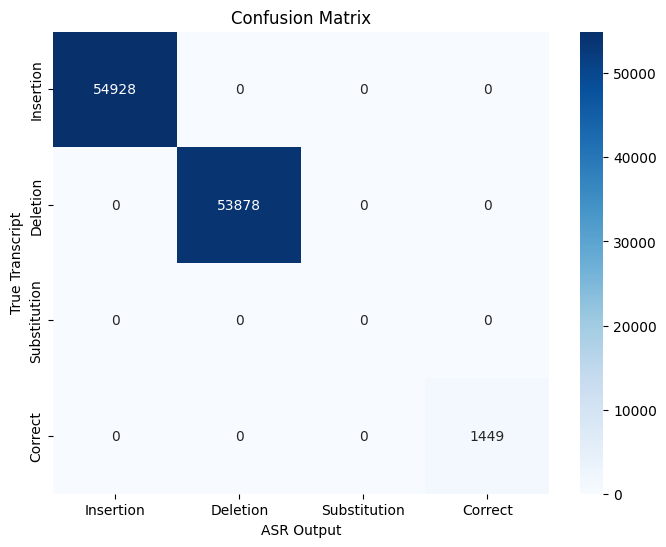

Average WER: 8.24%


In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from jiwer import wer

# Directories containing the transcripts
true_transcripts_dir = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/true label",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/true label",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/true label"
]

asr_transcripts_dir = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Function to read all files in a directory into a list
def read_transcripts_from_directory(directory):
    transcripts = []
    for filename in sorted(os.listdir(directory)):  # Ensure files are read in order
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r') as file:
                transcripts.append(file.read().strip())
    return transcripts

# Read true and ASR transcripts from the directories
true_transcripts = [read_transcripts_from_directory(directory) for directory in true_transcripts_dir]
asr_transcripts = [read_transcripts_from_directory(directory) for directory in asr_transcripts_dir]

# Ensure the same number of transcripts in both lists
assert all(len(true) == len(asr) for true, asr in zip(true_transcripts, asr_transcripts)), "Mismatch in the number of transcripts."

# Initialize confusion matrix for 4 error types (insertions, deletions, substitutions, correct)
confusion_matrix = np.zeros((4, 4), dtype=int)

error_types = {
    'I': 0,  # Insertions
    'D': 1,  # Deletions
    'S': 2,  # Substitutions
    'C': 3   # Correct
}

# Calculate WER and update confusion matrix
wers = []
for true_set, asr_set in zip(true_transcripts, asr_transcripts):
    for true_text, asr_text in zip(true_set, asr_set):
        # Calculate WER
        error_rate = wer(true_text, asr_text)
        wers.append(error_rate)

        # Split texts into words
        true_words = true_text.split()
        asr_words = asr_text.split()

        # Compute aligned words
        true_idx = 0
        asr_idx = 0
        while true_idx < len(true_words) or asr_idx < len(asr_words):
            if true_idx < len(true_words) and asr_idx < len(asr_words) and true_words[true_idx] == asr_words[asr_idx]:
                # Correct match
                confusion_matrix[error_types['C'], error_types['C']] += 1
                true_idx += 1
                asr_idx += 1
            elif asr_idx < len(asr_words) and (true_idx == len(true_words) or true_words[true_idx] != asr_words[asr_idx]):
                # Insertion error
                confusion_matrix[error_types['I'], error_types['I']] += 1
                asr_idx += 1
            elif true_idx < len(true_words) and (asr_idx == len(asr_words) or true_words[true_idx] != asr_words[asr_idx]):
                # Deletion error
                confusion_matrix[error_types['D'], error_types['D']] += 1
                true_idx += 1
            elif true_idx < len(true_words) and asr_idx < len(asr_words) and true_words[true_idx] != asr_words[asr_idx]:
                # Substitution error
                confusion_matrix[error_types['S'], error_types['S']] += 1
                true_idx += 1
                asr_idx += 1

# Print confusion matrix
labels = ['Insertion', 'Deletion', 'Substitution', 'Correct']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('ASR Output')
plt.ylabel('True Transcript')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print the average WER
average_wer = sum(wers) / len(wers)
print(f"Average WER: {average_wer:.2%}")

`NOTES`: Given na to mababa talaga scores, pero tignan natin ano pa pwedeng insight dito  

Add din ng confusion matrix dapat

### Comparison of TM Techniques

#### Evaluation Metrics

In [ ]:
# LDA MODELING TECHNIQUE EVLAUATION | COHERENCE SCORE

from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

# Coherence Score

tokenized_corpus = [doc.split() for doc in processed_corpus]
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_corpus, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score (c_v):", coherence_lda)

# Perplexity Score

perplexity_lda = lda_model.log_perplexity(corpus_bow)
print("Perplexity Score:", perplexity_lda)

Coherence Score (c_v): 0.7379226313046594
Perplexity Score: -13.926265208634288


In [ ]:
# BERTopic TECHNIQUE EVALUATION | COHERENCE SCORE

tokenized_corpus = [doc.split() for doc in processed_corpus]
dictionary = Dictionary(tokenized_corpus)

# Coherence Score with 'c_v' coherence measure
coherence_model_bertopic = CoherenceModel(model=topic_model, texts=tokenized_corpus, dictionary=dictionary, coherence='c_v')
coherence_bertopic = coherence_model_bertopic.get_coherence()
print("Coherence Score (c_v) for BERTopic:", coherence_bertopic)

Coherence Score (c_v) for BERTopic: 1.0


In [ ]:
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import numpy as np

# Assuming tokenized_corpus and dictionary are defined earlier
# Initialize RoBERTa-based Sentence Transformer model
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Join tokens into strings for BERTopic
docs = [" ".join(doc) for doc in tokenized_corpus]

# Calculate average word embeddings for each document and store in a list
embeddings_list = []
for doc in tokenized_corpus:
    if len(doc) > 0:
        doc_embeddings = embedding_model.encode(doc)
        avg_embedding = np.mean(doc_embeddings, axis=0)
        normalized_embedding = avg_embedding / np.linalg.norm(avg_embedding)  # Manual normalization
        embeddings_list.append(normalized_embedding)
    else:
        embeddings_list.append(np.zeros(embedding_model.get_sentence_embedding_dimension()))  # Handle empty documents

# Convert the list of embeddings to a NumPy array
embeddings = np.vstack(embeddings_list)  # Stack the embeddings into a 2D array

# Create BERTopic model instance
topic_model = BERTopic()

# Fit BERTopic model with documents and embeddings
topics, _ = topic_model.fit_transform(docs, embeddings=embeddings)

# Extract the topics
topic_words = topic_model.get_topics()

# Prepare the topics in the format required by Gensim
formatted_topics = []
for topic in topic_words.values():
    formatted_topics.append([word for word, _ in topic])

# Ensure no empty topics are included
formatted_topics = [topic for topic in formatted_topics if topic]

# Create a dictionary representation of the documents
dictionary = Dictionary(tokenized_corpus)

# Print number of documents and first few documents for diagnosis
print("Number of documents:", len(docs))
print("First few documents:", docs[:3])
print("Sample tokenized document:", tokenized_corpus[0][:10])

# Coherence Score with 'u_mass' coherence measure
coherence_model_umass = CoherenceModel(topics=formatted_topics, texts=tokenized_corpus, dictionary=dictionary, coherence='u_mass')
coherence_umass = coherence_model_umass.get_coherence()
print("Coherence Score (u_mass) for BERTopic:", coherence_umass)

# Coherence Score with 'c_uci' coherence measure
coherence_model_uci = CoherenceModel(topics=formatted_topics, texts=tokenized_corpus, dictionary=dictionary, coherence='c_uci')
coherence_uci = coherence_model_uci.get_coherence()
print("Coherence Score (c_uci) for BERTopic:", coherence_uci)

# Coherence Score with 'c_npmi' coherence measure
coherence_model_npmi = CoherenceModel(topics=formatted_topics, texts=tokenized_corpus, dictionary=dictionary, coherence='c_npmi')
coherence_npmi = coherence_model_npmi.get_coherence()
print("Coherence Score (c_npmi) for BERTopic:", coherence_npmi)

Number of documents: 21
First few documents: ['hmm hello everyone ganda topic mahirap mahalin totoo mahirapan mahalin mahalin mere fact nandito nagiexist kamahalmahal ganon mahirap mahalin welcome mind buddy millennial psychologist rian portuguese service siyempre siyempre nagtanong nung nakaraan mahirap mahalin ifeature listener napakainteresting sagot naghalohalo tema siyempre imemention tema nakuha audience alam makakarelate maiba tema sagot kinalaman condition worth maiba pagbibigay atensyon maiba pagkafroy desire namang kinalaman pagkukumpara simulan meron talagang naganswer mahirap daw mahalin keji dinedepende worth standard mahirap habulin ideal sineset naisip order worthy must please people feed ego mahal feel worthy nagsastart pagmamahal well fact first place validation love desire must came alam katotohanan sinabi time akala talagang mahal alam source love nagagaling ibang tao teka wala namang masama source love nagagaling ibang tao psychology fact pinaguusapan teorya mahalag

`NOTES`: Coherence Scores support c_v score (since it's close to 0)  